In [101]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn import over_sampling
from sklearn.preprocessing import StandardScaler

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.18.1
pandas version :  1.0.1
seaborn version :  0.10.0


In [102]:
data_2019 = pd.read_csv('Jan_2019_ontime.csv')
data_2020 = pd.read_csv('Jan_2020_ontime.csv')

data_2019['year'] = 2019
data_2020['year'] = 2020

In [103]:
#reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [104]:
data_2019 = reduce_mem_usage(data_2019)
data_2020 = reduce_mem_usage(data_2020)

Mem. usage decreased to 50.12 Mb (51.1% reduction)
Mem. usage decreased to 52.13 Mb (51.1% reduction)


Data yang akan dipakai untuk training adalah data 2019 dan data validasi adalah data 2020. Data_2019 dan 2020 akan digabungkan terlebih dahulu untuk dilakukan data cleansing dan feature engineering.

In [105]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int8   
 1   DAY_OF_WEEK            583985 non-null  int8   
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int16  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int16  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int16  
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int32  
 9   ORIGIN                 583985 non-null  object 
 10  DEST_AIRPORT_ID        583985 non-null  int16  
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int32  
 12  DEST                   583985 non-null  object 
 13  DEP_TIME               567633 non-null  float16
 14  DEP_DEL15              567630 non-nu

# Deskripsi Kolom (Fitur)
1. DAY_OF_MONTH: Hari dalam sebulan
2. DAY_OF_WEEK: Hari dalam seminggu
3. OP_UNIQUE_CARRIER: Kode unik transport
4. OP_CARRIER_AIRLINE_ID: Kode unik maskapai penerbangan
5. OP_CARRIER: Kode unik operator
6. TAIL_NUM: Kode pesawat
7. OP_CARRIER_FL_NUM: Kode flight
8. ORIGIN_AIRPORT_ID: ID airport asal
9. ORIGIN_AIRPORT_SEQ_ID: ID - SEQ airport asal
10. ORIGIN: Airport asal
11. DEST_AIRPORT_ID: ID airport tujuan
12. DEST: Airport tujuan
13. DEP_TIME: Jam keberangkatan
14. DEP_DEL15: Indikator delay pada keberangkatan
15. DEP_TIME_BLK: Blok waktu keberangkatan
16. ARR_TIME: Jam tiba
17. ARR_DEL15: Indikator delay pada kedatangan
18. CANCELLED: Indikator penerbangan yang dibatalkan
19. DIVERTED: Indikator penerbangan yang dialihkan
20. DISTANCE: Jarak antar airport

Masing-masing data akan ditambahkan fitur Date dan timestamp ARR_TIME & DEP_TIME untuk menghasilkan fitur DURATION (durasi) penerbangan.

In [106]:
date = []
dep_time =[]
arr_time = []

for i in data_2019['DAY_OF_MONTH']:
# for i, value in enumerate(df_temp['DAY_OF_MONTH']):
    if len(str(i)) ==1:
        date.append('2019-01-0{0}'.format(i))
    else:
        date.append('2019-01-{0}'.format(i))
        
data_2019['DATE'] = date


for i in data_2019['DEP_TIME']:
    if len(str(i)) == 5:
        dep_time.append(str(i)[0:3][:1] + ':' + str(i)[0:3][1:])
    elif len(str(i)) == 6:
        dep_time.append(str(i)[0:4][:2] + ':' + str(i)[0:4][2:])
    else :
        dep_time.append('a')

for i in data_2019['ARR_TIME']:
    if len(str(i)) == 5:
        arr_time.append(str(i)[0:3][:1] + ':' + str(i)[0:3][1:])
    elif len(str(i)) == 6:
        arr_time.append(str(i)[0:4][:2] + ':' + str(i)[0:4][2:])
    else :
        arr_time.append('a')

data_2019['dt_DEP_TIME'] = dep_time
data_2019['dt_ARR_TIME'] = arr_time

data_2019.drop(data_2019[data_2019['dt_DEP_TIME'] == 'a'].index , inplace=True)
data_2019.drop(data_2019[data_2019['dt_ARR_TIME'] == 'a'].index , inplace=True)

data_2019.dt_DEP_TIME = data_2019.dt_DEP_TIME.replace({"24:00":"23:59"})
data_2019.dt_DEP_TIME = data_2019.dt_DEP_TIME.replace({"20:60":"21:00"})
data_2019.dt_DEP_TIME = data_2019.dt_DEP_TIME.replace({"21:60":"22:00"})
data_2019.dt_DEP_TIME = data_2019.dt_DEP_TIME.replace({"22:60":"23:00"})
data_2019.dt_DEP_TIME = data_2019.dt_DEP_TIME.replace({"23:60":"23:59"})
data_2019.dt_ARR_TIME = data_2019.dt_ARR_TIME.replace({"24:00":"23:59"})
data_2019.dt_ARR_TIME = data_2019.dt_ARR_TIME.replace({"20:60":"21:00"})
data_2019.dt_ARR_TIME = data_2019.dt_ARR_TIME.replace({"21:60":"22:00"})
data_2019.dt_ARR_TIME = data_2019.dt_ARR_TIME.replace({"22:60":"23:00"})
data_2019.dt_ARR_TIME = data_2019.dt_ARR_TIME.replace({"23:60":"23:59"})


data_2019['dt_DEP_TIME'] = data_2019['DATE'] + ' ' +data_2019['dt_DEP_TIME']
data_2019['dt_ARR_TIME'] = data_2019['DATE'] + ' ' +data_2019['dt_ARR_TIME']


import datetime

data_2019['dt_DEP_TIME'] = pd.to_datetime(data_2019['dt_DEP_TIME'],format= '%Y-%m-%d %H:%M' )
data_2019['dt_ARR_TIME'] = pd.to_datetime(data_2019['dt_ARR_TIME'],format= '%Y-%m-%d %H:%M' )

In [107]:
date = []
dep_time =[]
arr_time = []

for i in data_2020['DAY_OF_MONTH']:
# for i, value in enumerate(df_temp['DAY_OF_MONTH']):
    if len(str(i)) ==1:
        date.append('2020-01-0{0}'.format(i))
    else:
        date.append('2020-01-{0}'.format(i))
        
data_2020['DATE'] = date


for i in data_2020['DEP_TIME']:
    if len(str(i)) == 5:
        dep_time.append(str(i)[0:3][:1] + ':' + str(i)[0:3][1:])
    elif len(str(i)) == 6:
        dep_time.append(str(i)[0:4][:2] + ':' + str(i)[0:4][2:])
    else :
        dep_time.append('a')

for i in data_2020['ARR_TIME']:
    if len(str(i)) == 5:
        arr_time.append(str(i)[0:3][:1] + ':' + str(i)[0:3][1:])
    elif len(str(i)) == 6:
        arr_time.append(str(i)[0:4][:2] + ':' + str(i)[0:4][2:])
    else :
        arr_time.append('a')

data_2020['dt_DEP_TIME'] = dep_time
data_2020['dt_ARR_TIME'] = arr_time

data_2020.drop(data_2020[data_2020['dt_DEP_TIME'] == 'a'].index , inplace=True)
data_2020.drop(data_2020[data_2020['dt_ARR_TIME'] == 'a'].index , inplace=True)

data_2020.dt_DEP_TIME = data_2020.dt_DEP_TIME.replace({"24:00":"23:59"})
data_2020.dt_DEP_TIME = data_2020.dt_DEP_TIME.replace({"20:60":"21:00"})
data_2020.dt_DEP_TIME = data_2020.dt_DEP_TIME.replace({"21:60":"22:00"})
data_2020.dt_DEP_TIME = data_2020.dt_DEP_TIME.replace({"22:60":"23:00"})
data_2020.dt_DEP_TIME = data_2020.dt_DEP_TIME.replace({"23:60":"23:59"})
data_2020.dt_ARR_TIME = data_2020.dt_ARR_TIME.replace({"24:00":"23:59"})
data_2020.dt_ARR_TIME = data_2020.dt_ARR_TIME.replace({"20:60":"21:00"})
data_2020.dt_ARR_TIME = data_2020.dt_ARR_TIME.replace({"21:60":"22:00"})
data_2020.dt_ARR_TIME = data_2020.dt_ARR_TIME.replace({"22:60":"23:00"})
data_2020.dt_ARR_TIME = data_2020.dt_ARR_TIME.replace({"23:60":"23:59"})


data_2020['dt_DEP_TIME'] = data_2020['DATE'] + ' ' +data_2020['dt_DEP_TIME']
data_2020['dt_ARR_TIME'] = data_2020['DATE'] + ' ' +data_2020['dt_ARR_TIME']


import datetime

data_2020['dt_DEP_TIME'] = pd.to_datetime(data_2020['dt_DEP_TIME'],format= '%Y-%m-%d %H:%M' )
data_2020['dt_ARR_TIME'] = pd.to_datetime(data_2020['dt_ARR_TIME'],format= '%Y-%m-%d %H:%M' )

In [108]:
#menggabungkan 2 data
data_all = pd.concat([data_2019, data_2020])
data_all.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21,year,DATE,dt_DEP_TIME,dt_ARR_TIME
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,722.0,0.0,0.0,0.0,300.0,NaN,2019,2019-01-01,2019-01-01 06:01:00,2019-01-01 07:22:00
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,1633.0,0.0,0.0,0.0,596.0,NaN,2019,2019-01-01,2019-01-01 13:59:00,2019-01-01 16:33:00
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,1329.0,0.0,0.0,0.0,229.0,NaN,2019,2019-01-01,2019-01-01 12:15:00,2019-01-01 13:29:00
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,1625.0,0.0,0.0,0.0,223.0,NaN,2019,2019-01-01,2019-01-01 15:21:00,2019-01-01 16:25:00
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,1940.0,0.0,0.0,0.0,579.0,NaN,2019,2019-01-01,2019-01-01 18:47:00,2019-01-01 19:40:00


## Deskripsi data

In [109]:
data_all.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEP_TIME,DEP_DEL15,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21,year
count,1.143959e+06,1.143959e+06,1.143959e+06,1.143959e+06,1.143959e+06,1.143959e+06,1.143959e+06,1.143959e+06,1143959.0,1143959.0,1143959.0,1142087.0,1143959.0,1.143959e+06,1143959.0,0.0,1.143959e+06
mean,1.592231e+01,3.892722e+00,1.998779e+04,2.582152e+03,1.265584e+04,1.265588e+06,1.265566e+04,1.265570e+06,NaN,NaN,NaN,NaN,0.0,1.636505e-03,NaN,NaN,2.019514e+03
std,8.983674e+00,1.916540e+00,3.761256e+02,1.823663e+03,1.524559e+03,1.524556e+05,1.522720e+03,1.522717e+05,NaN,0.0,NaN,0.0,0.0,4.043579e-02,NaN,NaN,4.997982e-01
min,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,1.013500e+04,1.013505e+06,1.013500e+04,1.013505e+06,100.0,0.0,100.0,0.0,0.0,0.000000e+00,31.0,NaN,2.019000e+03
25%,8.000000e+00,2.000000e+00,1.979000e+04,1.030000e+03,1.129200e+04,1.129202e+06,1.129200e+04,1.129202e+06,918.0,0.0,1116.0,0.0,0.0,0.000000e+00,365.0,NaN,2.019000e+03
50%,1.600000e+01,4.000000e+00,1.997700e+04,2.142000e+03,1.288900e+04,1.288903e+06,1.288900e+04,1.288903e+06,1320.0,0.0,1525.0,0.0,0.0,0.000000e+00,638.0,NaN,2.020000e+03
75%,2.400000e+01,5.000000e+00,2.036800e+04,4.013000e+03,1.402700e+04,1.402702e+06,1.402700e+04,1.402702e+06,1728.0,0.0,1924.0,0.0,0.0,0.000000e+00,1034.0,NaN,2.020000e+03
max,3.100000e+01,7.000000e+00,2.045200e+04,7.439000e+03,1.686900e+04,1.686901e+06,1.686900e+04,1.686901e+06,2400.0,1.0,2400.0,1.0,0.0,1.000000e+00,5096.0,NaN,2.020000e+03


In [110]:
data_all.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21,year,DATE,dt_DEP_TIME,dt_ARR_TIME
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,722.0,0.0,0.0,0.0,300.0,NaN,2019,2019-01-01,2019-01-01 06:01:00,2019-01-01 07:22:00
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,1633.0,0.0,0.0,0.0,596.0,NaN,2019,2019-01-01,2019-01-01 13:59:00,2019-01-01 16:33:00
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,1329.0,0.0,0.0,0.0,229.0,NaN,2019,2019-01-01,2019-01-01 12:15:00,2019-01-01 13:29:00
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,1625.0,0.0,0.0,0.0,223.0,NaN,2019,2019-01-01,2019-01-01 15:21:00,2019-01-01 16:25:00
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,1940.0,0.0,0.0,0.0,579.0,NaN,2019,2019-01-01,2019-01-01 18:47:00,2019-01-01 19:40:00


## Data Cleansing

In [111]:
data_all.isnull().sum()

DAY_OF_MONTH                   0
DAY_OF_WEEK                    0
OP_UNIQUE_CARRIER              0
OP_CARRIER_AIRLINE_ID          0
OP_CARRIER                     0
TAIL_NUM                       0
OP_CARRIER_FL_NUM              0
ORIGIN_AIRPORT_ID              0
ORIGIN_AIRPORT_SEQ_ID          0
ORIGIN                         0
DEST_AIRPORT_ID                0
DEST_AIRPORT_SEQ_ID            0
DEST                           0
DEP_TIME                       0
DEP_DEL15                      0
DEP_TIME_BLK                   0
ARR_TIME                       0
ARR_DEL15                   1872
CANCELLED                      0
DIVERTED                       0
DISTANCE                       0
Unnamed: 21              1143959
year                           0
DATE                           0
dt_DEP_TIME                    0
dt_ARR_TIME                    0
dtype: int64

In [112]:
data_missing_value = data_all.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(data_all))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage
0,Unnamed: 21,1143959,100.00
1,ARR_DEL15,1872,0.16


In [113]:
# Menghapus kolom Unnamed: 21, 'OP_UNIQUE_CARRIER','OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID'
data_all = data_all.drop(['OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21', 'CANCELLED', 'DIVERTED'], axis=1)

In [114]:
# Hapus semua baris yang memiliki nilai yang hilang
data_all = data_all.dropna()

In [115]:
data_all.isnull().sum()

DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
OP_CARRIER_FL_NUM    0
ORIGIN               0
DEST                 0
DEP_TIME             0
DEP_DEL15            0
DEP_TIME_BLK         0
ARR_TIME             0
ARR_DEL15            0
DISTANCE             0
year                 0
DATE                 0
dt_DEP_TIME          0
dt_ARR_TIME          0
dtype: int64

In [116]:
data_all.shape

(1142087, 16)

## Duplicate values

In [117]:
data_all.duplicated().sum()

0

## Feature Engineering

1. Penambahan Fitur DURATION dan kategorinya (CAT_DURATION) berdasarkan durasi penerbangan
- Short: 0-3 jam
- Medium: 3-6 jam
- Long: > 6 jam

In [118]:
data_all['DURATION'] = data_all['dt_ARR_TIME'] - data_all['dt_DEP_TIME']

In [119]:
cat_duration = []
for i in data_all['DURATION']:
    if i >= datetime.timedelta(hours=0) and i < datetime.timedelta(hours=3) :
        cat_duration.append('Short')
    elif i >= datetime.timedelta(hours=3) and i <= datetime.timedelta(hours=6):
        cat_duration.append('Medium')
    else:
        cat_duration.append('Long')
        
data_all['CAT_DURATION'] = cat_duration

In [120]:
data_all.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE,year,DATE,dt_DEP_TIME,dt_ARR_TIME,DURATION,CAT_DURATION
0,1,2,9E,3280,GNV,ATL,601.0,0.0,0600-0659,722.0,0.0,300.0,2019,2019-01-01,2019-01-01 06:01:00,2019-01-01 07:22:00,01:21:00,Short
1,1,2,9E,3281,MSP,CVG,1359.0,0.0,1400-1459,1633.0,0.0,596.0,2019,2019-01-01,2019-01-01 13:59:00,2019-01-01 16:33:00,02:34:00,Short
2,1,2,9E,3282,DTW,CVG,1215.0,0.0,1200-1259,1329.0,0.0,229.0,2019,2019-01-01,2019-01-01 12:15:00,2019-01-01 13:29:00,01:14:00,Short
3,1,2,9E,3283,TLH,ATL,1521.0,0.0,1500-1559,1625.0,0.0,223.0,2019,2019-01-01,2019-01-01 15:21:00,2019-01-01 16:25:00,01:04:00,Short
4,1,2,9E,3284,ATL,FSM,1847.0,0.0,1900-1959,1940.0,0.0,579.0,2019,2019-01-01,2019-01-01 18:47:00,2019-01-01 19:40:00,00:53:00,Short


2. Penambahan Fitur ROUTE (rute penerbangan) yang berasal dari penggabungan fitur ORIGIN & DESTINATION

In [121]:
data_all["ROUTE"] = data_all["ORIGIN"]+ '-' + data_all["DEST"]

3. Penambahan Fitur ARR_TIME_BLK (Arrival Time Block) yang berasal dari ARR_TIME

In [122]:
#generate block hours
blocks = []
for hour in range(0,24):
    hour_part = ('%02d' %(hour))
    blocks.append(hour_part + '00-' + hour_part + '59')
blocks

def get_arrival_time_blk(arr_time):
    arr_hour = str('%04d' %(arr_time))[:2]
    arr_block = None
    for block in blocks:
        #print (block,arr_hour)
        if block.startswith(arr_hour):
            arr_block = block
            break
    if arr_block == None and str(arr_time) == '2400.0':
        arr_block = '0000-0059'
        #print('Cannot find block for #' + str(arr_time) + '#: set block to #' + arr_block + '#')
    return arr_block

data_all['ARR_TIME_BLK'] = data_all.ARR_TIME.apply(get_arrival_time_blk)
data_all.reset_index(inplace=True)
data_all.head()

,index,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,...,ARR_DEL15,DISTANCE,year,DATE,dt_DEP_TIME,dt_ARR_TIME,DURATION,CAT_DURATION,ROUTE,ARR_TIME_BLK
0,0,1,2,9E,3280,GNV,ATL,601.0,0.0,0600-0659,...,0.0,300.0,2019,2019-01-01,2019-01-01 06:01:00,2019-01-01 07:22:00,01:21:00,Short,GNV-ATL,0700-0759
1,1,1,2,9E,3281,MSP,CVG,1359.0,0.0,1400-1459,...,0.0,596.0,2019,2019-01-01,2019-01-01 13:59:00,2019-01-01 16:33:00,02:34:00,Short,MSP-CVG,1600-1659
2,2,1,2,9E,3282,DTW,CVG,1215.0,0.0,1200-1259,...,0.0,229.0,2019,2019-01-01,2019-01-01 12:15:00,2019-01-01 13:29:00,01:14:00,Short,DTW-CVG,1300-1359
3,3,1,2,9E,3283,TLH,ATL,1521.0,0.0,1500-1559,...,0.0,223.0,2019,2019-01-01,2019-01-01 15:21:00,2019-01-01 16:25:00,01:04:00,Short,TLH-ATL,1600-1659
4,4,1,2,9E,3284,ATL,FSM,1847.0,0.0,1900-1959,...,0.0,579.0,2019,2019-01-01,2019-01-01 18:47:00,2019-01-01 19:40:00,00:53:00,Short,ATL-FSM,1900-1959


4. Menambah fitur kategori waktu penerbangan CAT_TIME berdasarkan kolom dt_ARR_TIME yang berisikan kategori sebagai berikut:
- Morning: penerbangan pagi (06.00-11.59)
- Afternoon: penerbangan siang (12.00-17.59)
- Evening: penerbangan malam (18.00-23.00)
- Midnight: penerbangan tengah malam (23.00-05.59)

In [123]:
cat_time = []
for i in data_all['ARR_TIME_BLK']:
    if i == '0600-0659' or i == '0700-0759' or i == '0800-0859' or i == '0900-0959'or i == '1000-1059'or i == '1100-1159':
        cat_time.append('Morning')
    elif i == '1200-1259'or i == '1300-1359'or i == '1400-1459'or i == '1500-1559'or i == '1600-1659'or i == '1700-1759' :
        cat_time.append('Afternoon')
    elif i == '1800-1859'or i == '1900-1959'or i == '2000-2059'or i == '2100-2159'or i == '2200-2259'or i == '2300-2359':
        cat_time.append('Evening')
    else:
        cat_time.append('Late night')

data_all['CAT_TIME'] = cat_time

5. Membuat kategori fitur distance (CAT_DISTANCE)

In [124]:
data_all['CAT_DISTANCE'] = pd.qcut(data_all['DISTANCE'], q=4, labels=['q1', 'q2', 'q3', 'q4'])

In [125]:
data_all = data_all.drop(['index'], axis=1)
data_all.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,...,year,DATE,dt_DEP_TIME,dt_ARR_TIME,DURATION,CAT_DURATION,ROUTE,ARR_TIME_BLK,CAT_TIME,CAT_DISTANCE
0,1,2,9E,3280,GNV,ATL,601.0,0.0,0600-0659,722.0,...,2019,2019-01-01,2019-01-01 06:01:00,2019-01-01 07:22:00,01:21:00,Short,GNV-ATL,0700-0759,Morning,q1
1,1,2,9E,3281,MSP,CVG,1359.0,0.0,1400-1459,1633.0,...,2019,2019-01-01,2019-01-01 13:59:00,2019-01-01 16:33:00,02:34:00,Short,MSP-CVG,1600-1659,Afternoon,q2
2,1,2,9E,3282,DTW,CVG,1215.0,0.0,1200-1259,1329.0,...,2019,2019-01-01,2019-01-01 12:15:00,2019-01-01 13:29:00,01:14:00,Short,DTW-CVG,1300-1359,Afternoon,q1
3,1,2,9E,3283,TLH,ATL,1521.0,0.0,1500-1559,1625.0,...,2019,2019-01-01,2019-01-01 15:21:00,2019-01-01 16:25:00,01:04:00,Short,TLH-ATL,1600-1659,Afternoon,q1
4,1,2,9E,3284,ATL,FSM,1847.0,0.0,1900-1959,1940.0,...,2019,2019-01-01,2019-01-01 18:47:00,2019-01-01 19:40:00,00:53:00,Short,ATL-FSM,1900-1959,Evening,q2


In [126]:
data_all.shape

(1142087, 22)

## Data Numerik

In [127]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data_all.select_dtypes(include=numerics).columns)
print(data_all.select_dtypes(include=numerics).shape)
data_num = data_all.select_dtypes(include=numerics)
data_num.head()

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_FL_NUM', 'DEP_TIME',
       'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15', 'DISTANCE', 'year'],
      dtype='object')

(1142087, 9)


,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,DEP_TIME,DEP_DEL15,ARR_TIME,ARR_DEL15,DISTANCE,year
0,1,2,3280,601.0,0.0,722.0,0.0,300.0,2019
1,1,2,3281,1359.0,0.0,1633.0,0.0,596.0,2019
2,1,2,3282,1215.0,0.0,1329.0,0.0,229.0,2019
3,1,2,3283,1521.0,0.0,1625.0,0.0,223.0,2019
4,1,2,3284,1847.0,0.0,1940.0,0.0,579.0,2019


## Data Non Numerik (object)

In [128]:
display(data_all.select_dtypes(include=['object']).columns)
print(data_all.select_dtypes(include=object).shape)
data_obj = data_all.select_dtypes(include=['object'])
data_obj.head()

Index(['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK', 'DATE',
       'CAT_DURATION', 'ROUTE', 'ARR_TIME_BLK', 'CAT_TIME'],
      dtype='object')

(1142087, 9)


,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_BLK,DATE,CAT_DURATION,ROUTE,ARR_TIME_BLK,CAT_TIME
0,9E,GNV,ATL,0600-0659,2019-01-01,Short,GNV-ATL,0700-0759,Morning
1,9E,MSP,CVG,1400-1459,2019-01-01,Short,MSP-CVG,1600-1659,Afternoon
2,9E,DTW,CVG,1200-1259,2019-01-01,Short,DTW-CVG,1300-1359,Afternoon
3,9E,TLH,ATL,1500-1559,2019-01-01,Short,TLH-ATL,1600-1659,Afternoon
4,9E,ATL,FSM,1900-1959,2019-01-01,Short,ATL-FSM,1900-1959,Evening


# Exploratory Data Analysis

## EDA untuk seluruh data penerbangan

In [129]:
data_all_2020 = data_all[data_all['year']==2020]
data_all_2019= data_all[data_all['year']==2019]

In [130]:
data_all.shape

(1142087, 22)

### Statistical Summary

In [131]:
#data numerik
data_num.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,DEP_TIME,DEP_DEL15,ARR_TIME,ARR_DEL15,DISTANCE,year
count,1.142087e+06,1.142087e+06,1.142087e+06,1142087.0,1142087.0,1142087.0,1142087.0,1142087.0,1.142087e+06
mean,1.592210e+01,3.892623e+00,2.581653e+03,NaN,NaN,NaN,NaN,NaN,2.019514e+03
std,8.983548e+00,1.916504e+00,1.823520e+03,NaN,0.0,NaN,0.0,NaN,4.997982e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,100.0,0.0,100.0,0.0,31.0,2.019000e+03
25%,8.000000e+00,2.000000e+00,1.030000e+03,918.0,0.0,1116.0,0.0,364.0,2.019000e+03
50%,1.600000e+01,4.000000e+00,2.141000e+03,1320.0,0.0,1525.0,0.0,637.0,2.020000e+03
75%,2.400000e+01,5.000000e+00,4.012000e+03,1728.0,0.0,1924.0,0.0,1034.0,2.020000e+03
max,3.100000e+01,7.000000e+00,7.439000e+03,2400.0,1.0,2400.0,1.0,5096.0,2.020000e+03


In [132]:
#data object
data_obj.describe()

,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_BLK,DATE,CAT_DURATION,ROUTE,ARR_TIME_BLK,CAT_TIME
count,1142087,1142087,1142087,1142087,1142087,1142087,1142087,1142087,1142087
unique,17,353,353,19,62,3,5939,24,4
top,WN,ATL,ATL,0600-0659,2020-01-06,Short,SFO-LAX,1600-1659,Afternoon
freq,211369,61282,62206,84356,20462,897173,2358,73726,420802


### Persebaran Data Analisis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000202081A8A48>,
      dtype=object)

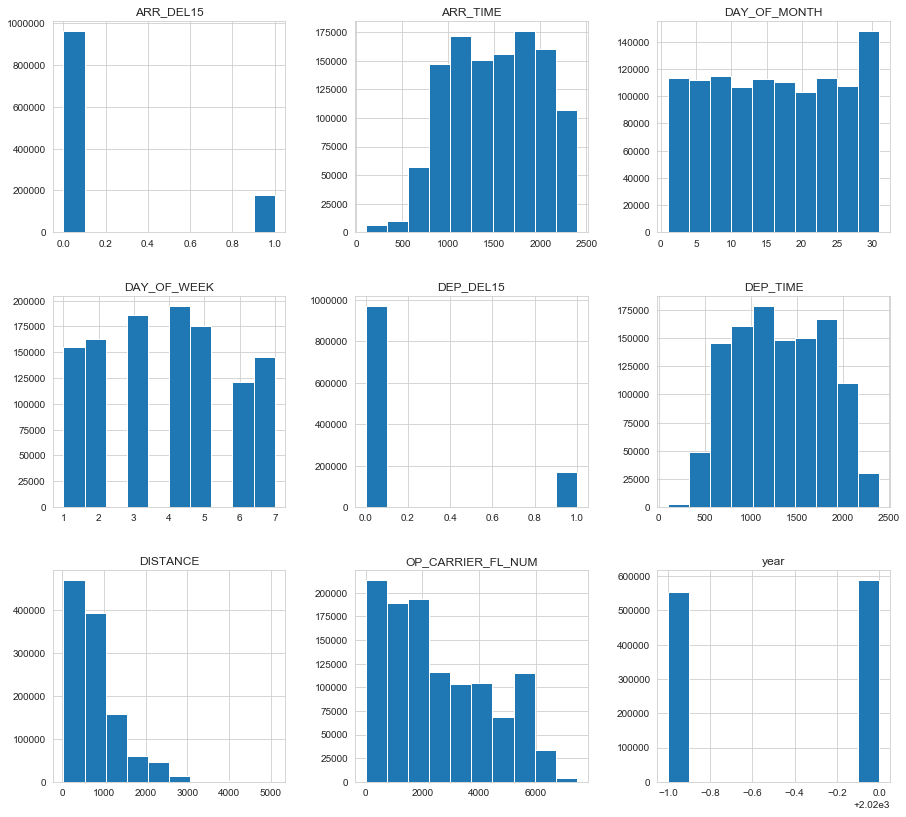

In [133]:
#Histogram
data_all.hist(figsize= (15, 14))

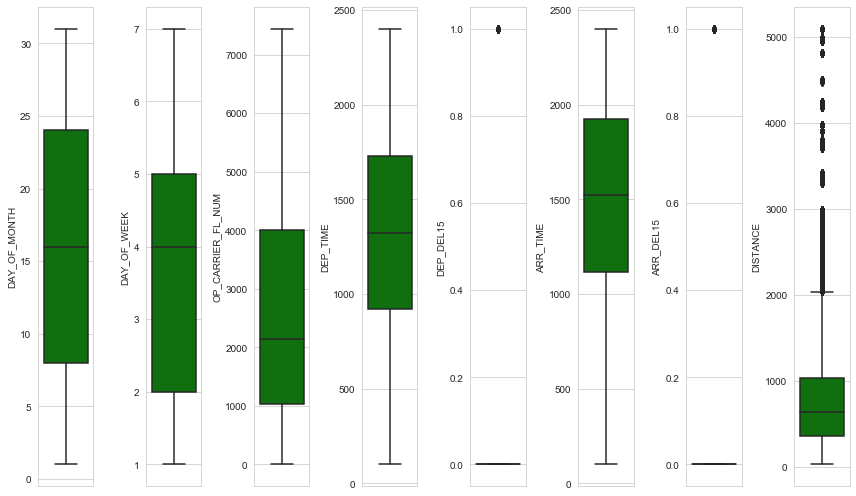

In [134]:
#boxplot
features = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_FL_NUM', 'DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15', 'DISTANCE']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 10, i+1)
    sns.boxplot(data_all[features[i]],color='green',orient='v')
    plt.tight_layout()
    
plt.savefig('numerical boxplot.png')

Terdapat outliers pada fitur DISTANCE dan perlu dilakukan transformasi data sebelum dilakukan modelling.

### Countplot

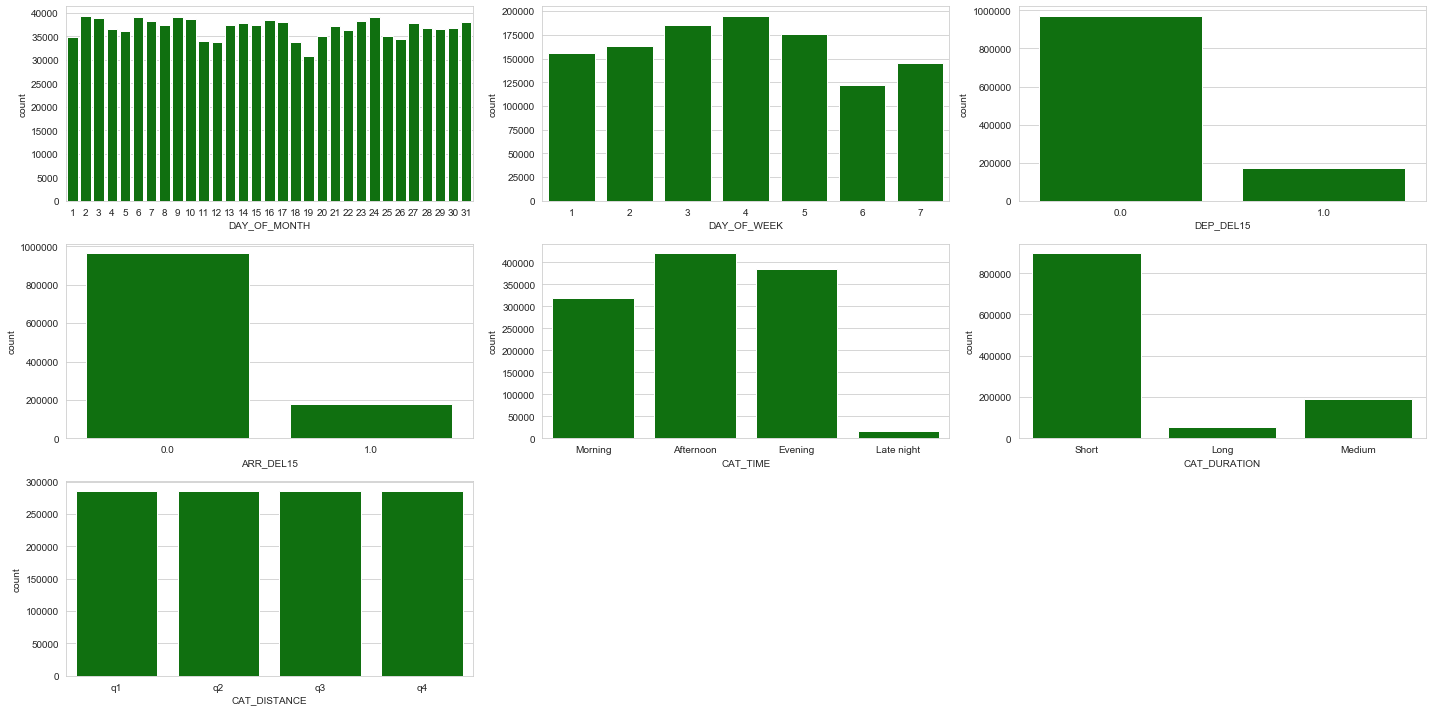

In [135]:
features = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'ARR_DEL15', 'CAT_TIME', 'CAT_DURATION', 'CAT_DISTANCE']
plt.figure(figsize=(20, 10))
for i in range(0, len(features)):
    plt.subplot(3, 3, i+1)
    sns.countplot(data_all[features[i]],color='green',orient='v')
    plt.tight_layout()
    
plt.savefig('categorical countplot.png')

Terdapat class imbalace pada data DEP_DEL15 dan ARR_DEL15, perlu dilakukan oversampling untuk membuat kelas seimbang.

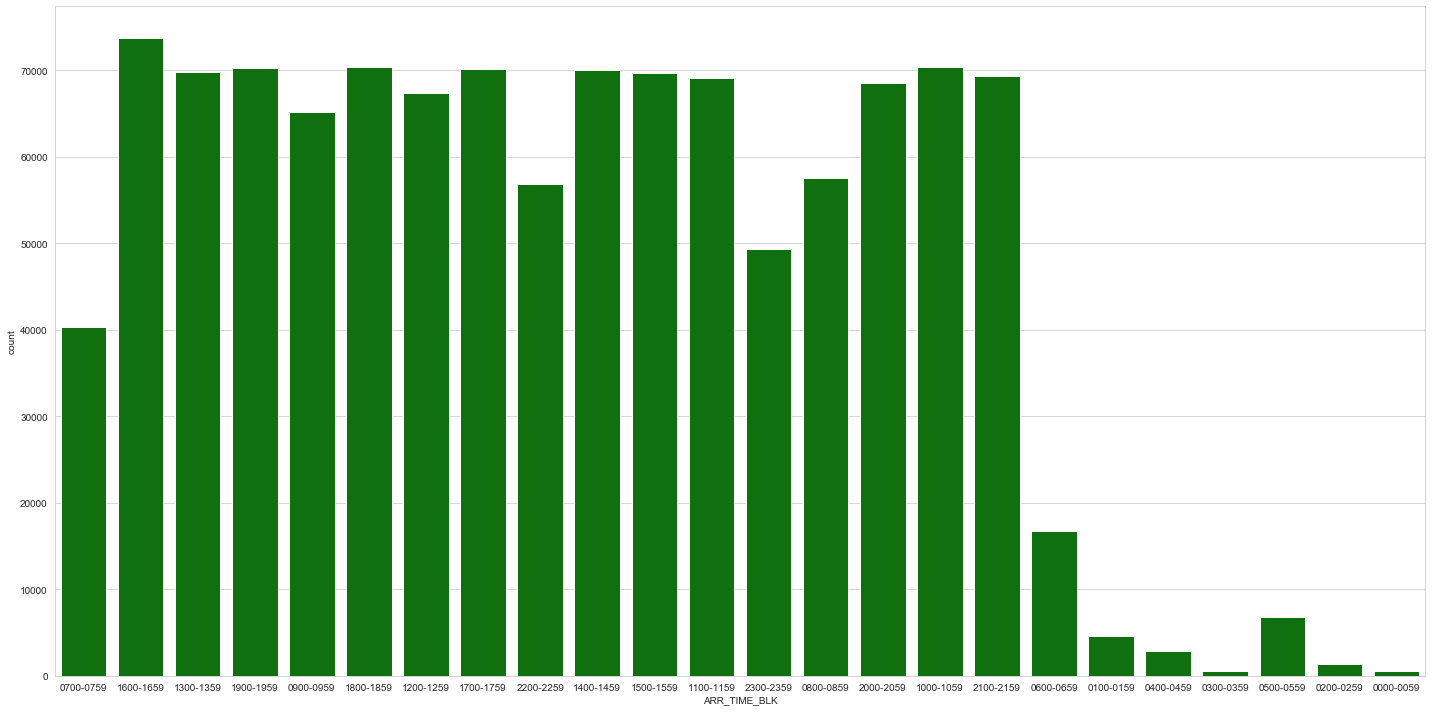

In [136]:
plt.figure(figsize=(20, 10))
sns.countplot(x='ARR_TIME_BLK', data=data_all, color='green',orient='v')
plt.tight_layout()
plt.savefig('dep_time_blk_countplot.png')

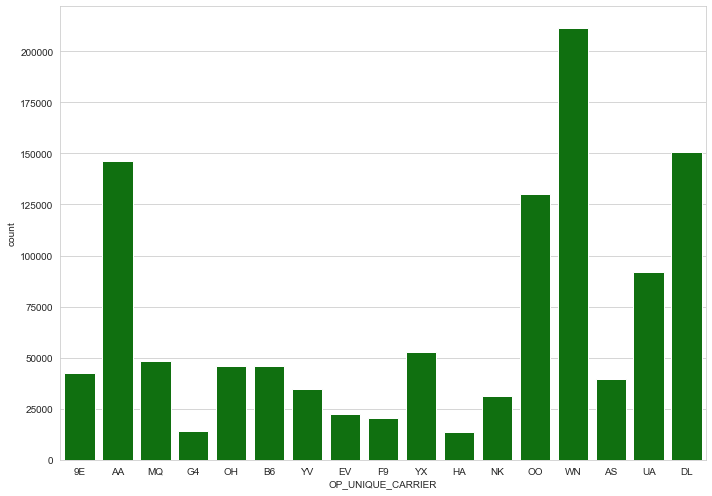

In [137]:
plt.figure(figsize=(10, 7))
sns.countplot(x='OP_UNIQUE_CARRIER', data=data_all, color='green',orient='v')
plt.tight_layout()

## EDA untuk data Maskapai American Airlines (AA)

In [138]:
data = data_all[data_all['OP_UNIQUE_CARRIER']=='AA']
data_2019 = data[data['year']==2019]
data_2020 = data[data['year']==2020]

In [139]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data.select_dtypes(include=numerics).columns)
print(data.select_dtypes(include=numerics).shape)
data_num = data.select_dtypes(include=numerics)
data_num.describe()

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_FL_NUM', 'DEP_TIME',
       'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15', 'DISTANCE', 'year'],
      dtype='object')

(146327, 9)


,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,DEP_TIME,DEP_DEL15,ARR_TIME,ARR_DEL15,DISTANCE,year
count,146327.000000,146327.000000,146327.000000,146327.0,146327.000000,146327.0,146327.000000,146327.0,146327.000000
mean,15.857518,3.921470,1501.903511,NaN,0.146606,NaN,0.161011,NaN,2019.500468
std,9.002599,1.919129,816.061777,NaN,0.353760,NaN,0.367432,NaN,0.500001
min,1.000000,1.000000,1.000000,100.0,0.000000,100.0,0.000000,83.0,2019.000000
25%,8.000000,2.000000,748.000000,859.0,0.000000,1113.0,0.000000,529.0,2019.000000
50%,16.000000,4.000000,1578.000000,1302.0,0.000000,1528.0,0.000000,868.0,2020.000000
75%,24.000000,5.000000,2186.000000,1722.0,0.000000,1931.0,0.000000,1235.0,2020.000000
max,31.000000,7.000000,2949.000000,2400.0,1.000000,2400.0,1.000000,4244.0,2020.000000


In [140]:
display(data.select_dtypes(include=['object']).columns)
print(data.select_dtypes(include=object).shape)
data_obj = data.select_dtypes(include=['object'])
data_obj.describe()

Index(['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK', 'DATE',
       'CAT_DURATION', 'ROUTE', 'ARR_TIME_BLK', 'CAT_TIME'],
      dtype='object')

(146327, 9)


,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_BLK,DATE,CAT_DURATION,ROUTE,ARR_TIME_BLK,CAT_TIME
count,146327,146327,146327,146327,146327,146327,146327,146327,146327
unique,1,113,113,19,62,3,827,24,4
top,AA,DFW,DFW,0700-0759,2020-01-03,Short,DFW-LAX,1300-1359,Afternoon
freq,146327,22521,23097,11527,2593,100486,788,9664,52762


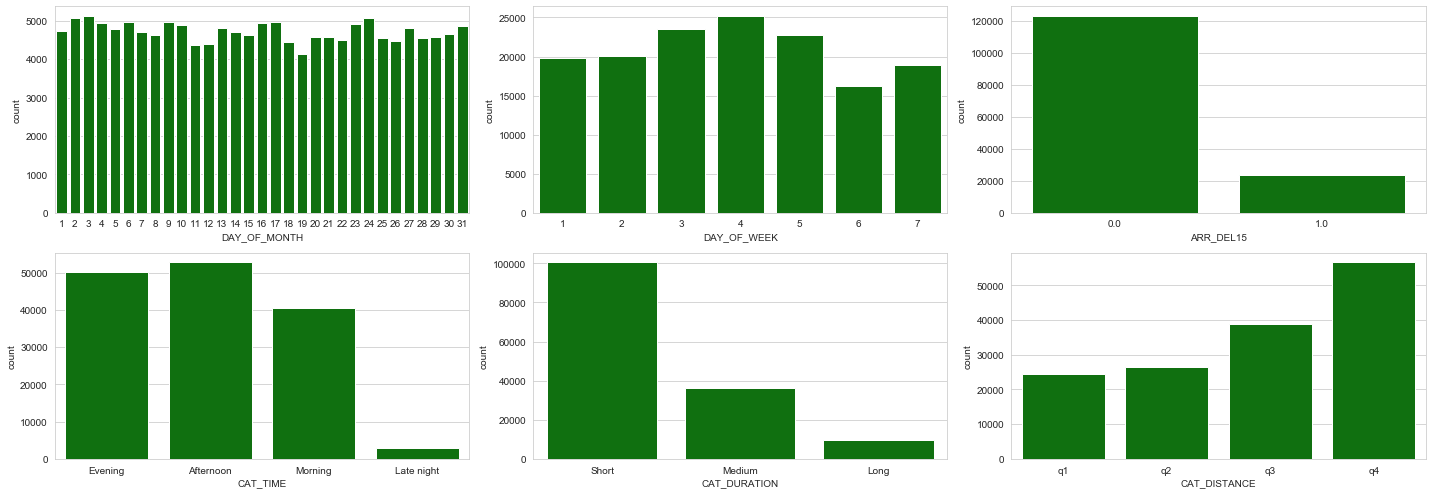

In [141]:
features = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'ARR_DEL15', 'CAT_TIME', 'CAT_DURATION', 'CAT_DISTANCE']
plt.figure(figsize=(20, 10))
for i in range(0, len(features)):
    plt.subplot(3, 3, i+1)
    sns.countplot(data[features[i]],color='green',orient='v')
    plt.tight_layout()
    
plt.savefig('AA categorical countplot.png')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002020B0F3EC8>,
      dtype=object)

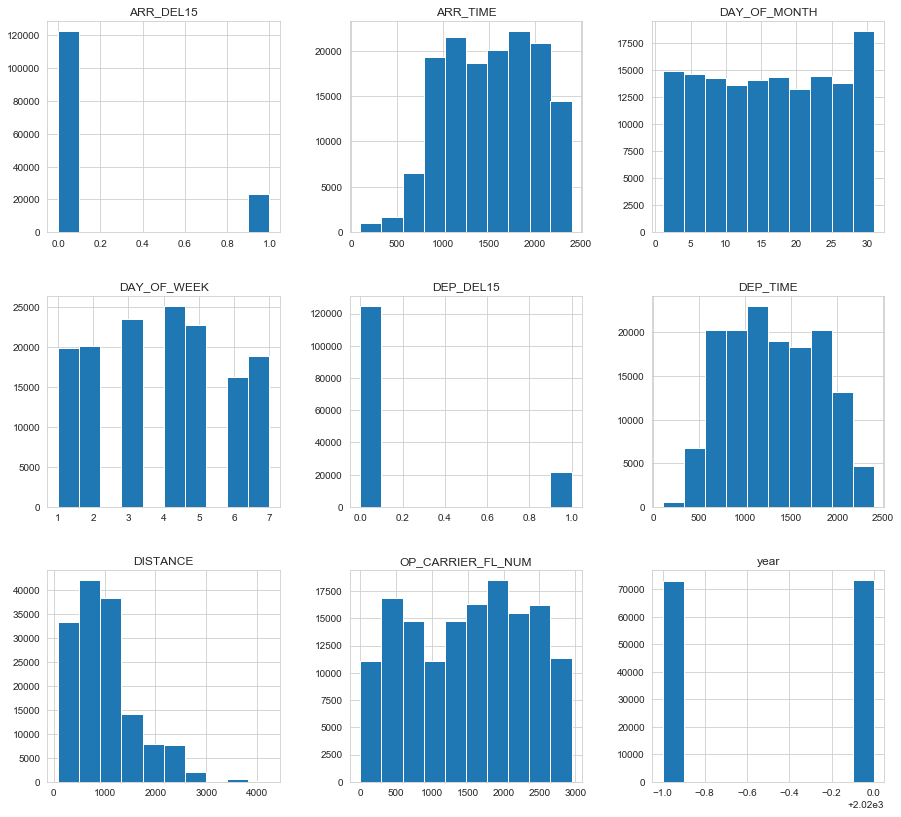

In [142]:
data.hist(figsize= (15, 14))

## Multivariate Analysis

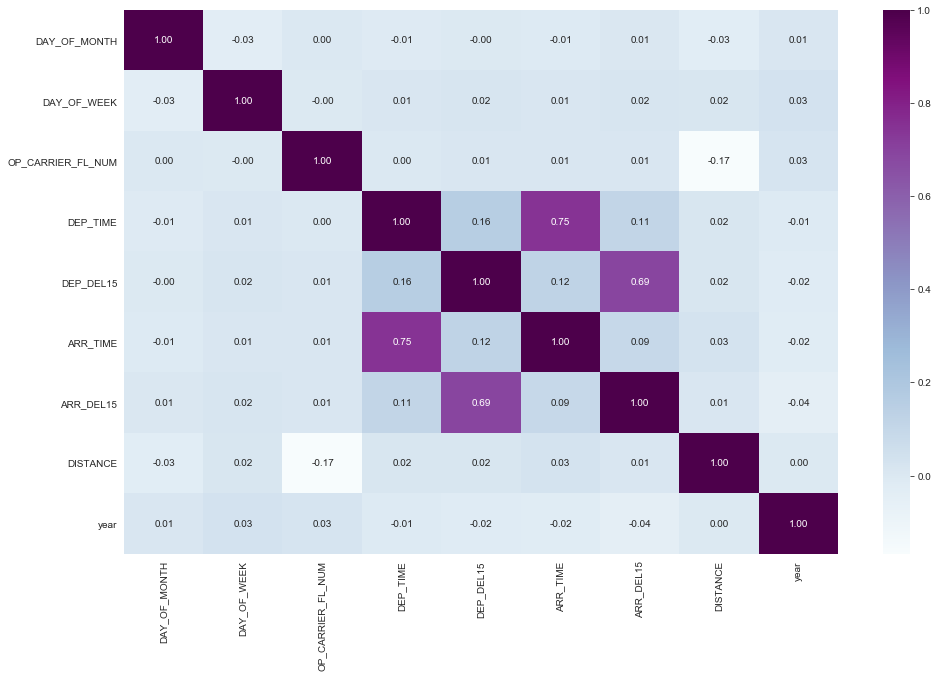

In [143]:
#features = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15','DISTANCE', 'DURATION']
corr_= data.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

Terdapat korelasi tinggi antara Jam Keberangkatan (DEP_TIME) dengan Jam kedatangan (ARR_TIME), begitu juga pada fitur DEP_DEL15 dan ARR_DEL15.
Salah satu fitur yang mempunyai korelasi tinggi dapat dihapus yaitu ARR_TIME dan ARR_DEL15.

# Insight

## Insight Persentase Delay berdasarkan Maskapai

In [144]:
#delay berdasarkan 5 Maskapai tersibuk tahun 2019
maskapai19 = data_all_2019[['OP_UNIQUE_CARRIER','ARR_DEL15']].groupby(['OP_UNIQUE_CARRIER']).sum()
maskapai19['FREQUENCY'] = data_all_2019.groupby(['OP_UNIQUE_CARRIER'])['ARR_DEL15'].count()
maskapai19 = maskapai19.sort_values(['FREQUENCY'], ascending=False)
maskapai19['PERCENTAGE'] = (maskapai19['ARR_DEL15']/maskapai19['FREQUENCY'])*100
maskapai19['AIRLINES'] = maskapai19.index
maskapai19 = maskapai19.sort_values(['FREQUENCY'], ascending=False)
maskapai19 = maskapai19.sort_values(['PERCENTAGE'], ascending=False)
maskapai19.head()

,ARR_DEL15,FREQUENCY,PERCENTAGE,AIRLINES
OP_UNIQUE_CARRIER,,,,
B6,5824.0,22326,26.086178,B6
G4,1689.0,6655,25.379414,G4
MQ,5676.0,23419,24.236731,MQ
EV,2908.0,12078,24.076834,EV
F9,2148.0,9001,23.864015,F9


In [145]:
#delay berdasarkan 5 Maskapai tersibuk tahun 2020
maskapai20 = data_all_2020[['OP_UNIQUE_CARRIER','ARR_DEL15']].groupby(['OP_UNIQUE_CARRIER']).sum()
maskapai20['FREQUENCY'] = data_all_2020.groupby(['OP_UNIQUE_CARRIER'])['ARR_DEL15'].count()
maskapai20['PERCENTAGE'] = (maskapai20['ARR_DEL15']/maskapai20['FREQUENCY'])*100
maskapai20['AIRLINES'] = maskapai20.index
maskapai20 = maskapai20.sort_values(['FREQUENCY'], ascending=False)
maskapai20 = maskapai20.sort_values(['PERCENTAGE'], ascending=False)
maskapai20.head()

,ARR_DEL15,FREQUENCY,PERCENTAGE,AIRLINES
OP_UNIQUE_CARRIER,,,,
OH,4896.0,23637,20.713288,OH
AS,4120.0,20082,20.515885,AS
G4,1483.0,7606,19.497765,G4
MQ,4856.0,25043,19.390648,MQ
YV,2980.0,17279,17.246368,YV


In [146]:
growth = maskapai19.merge(maskapai20, how='inner', on='AIRLINES')
growth['GROWTH'] = growth['PERCENTAGE_y'] - growth['PERCENTAGE_x'] 
growth.sort_values(['FREQUENCY_x', 'PERCENTAGE_x'], ascending=False)
growth.head()

,ARR_DEL15_x,FREQUENCY_x,PERCENTAGE_x,AIRLINES,ARR_DEL15_y,FREQUENCY_y,PERCENTAGE_y,GROWTH
0,5824.0,22326,26.086178,B6,3358.0,23682,14.179546,-11.906632
1,1689.0,6655,25.379414,G4,1483.0,7606,19.497765,-5.881649
2,5676.0,23419,24.236731,MQ,4856.0,25043,19.390648,-4.846083
3,2908.0,12078,24.076834,EV,1539.0,10304,14.935947,-9.140887
4,2148.0,9001,23.864015,F9,1636.0,11560,14.152249,-9.711766


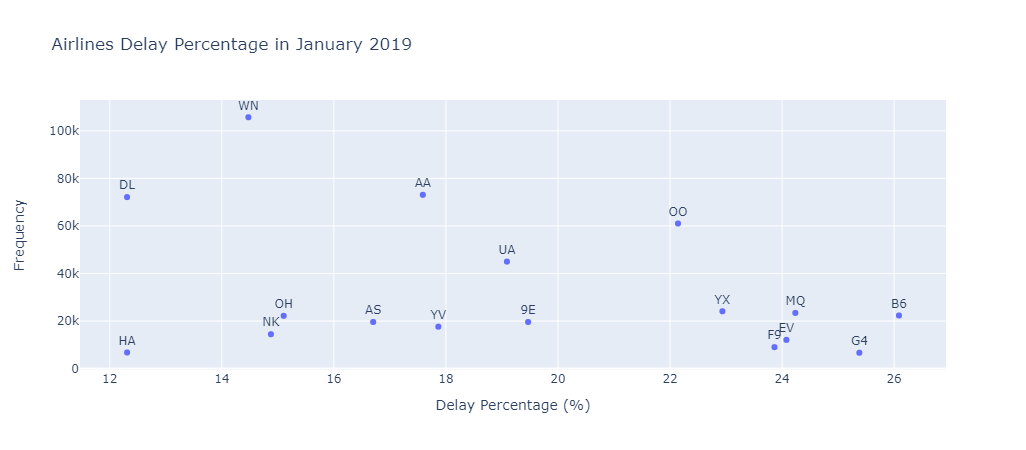

In [147]:
import plotly.express as px
fig = px.scatter(growth, x="PERCENTAGE_x", y="FREQUENCY_x",text="AIRLINES", title='Airlines Delay Percentage in January 2019', labels={
                     "PERCENTAGE_x": "Delay Percentage (%)",
                     "FREQUENCY_x": "Frequency",
                 })
fig.update_traces(textposition='top center')
fig.show()

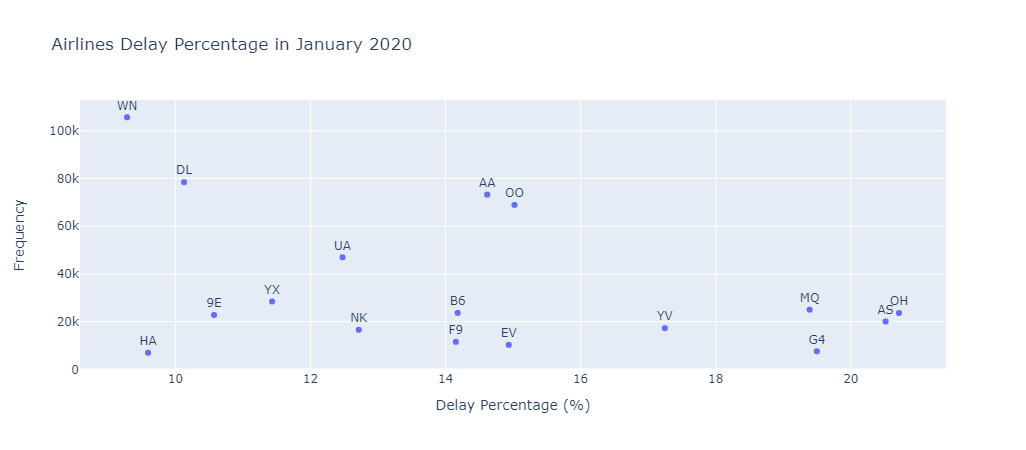

In [148]:
import plotly.express as px
fig = px.scatter(growth, x="PERCENTAGE_y", y="FREQUENCY_y",text="AIRLINES", title='Airlines Delay Percentage in January 2020', labels={
                     "PERCENTAGE_y": "Delay Percentage (%)",
                     "FREQUENCY_y": "Frequency",
                 })
fig.update_traces(textposition='top center')
fig.show()

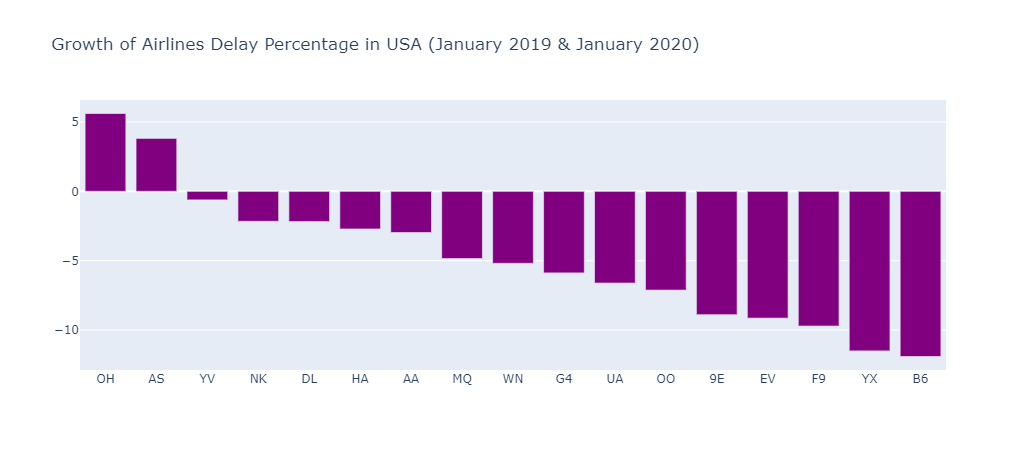

In [149]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
    x=growth.sort_values(by='GROWTH', ascending=False)['AIRLINES'].values,
    y=growth.sort_values(by='GROWTH', ascending=False)['GROWTH'].values,
    marker_color='purple'
))

fig.update_layout(barmode='group',
                 title = 'Growth of Airlines Delay Percentage in USA (January 2019 & January 2020)')
fig.show()

## Insight Persentase delay pada Tanggal

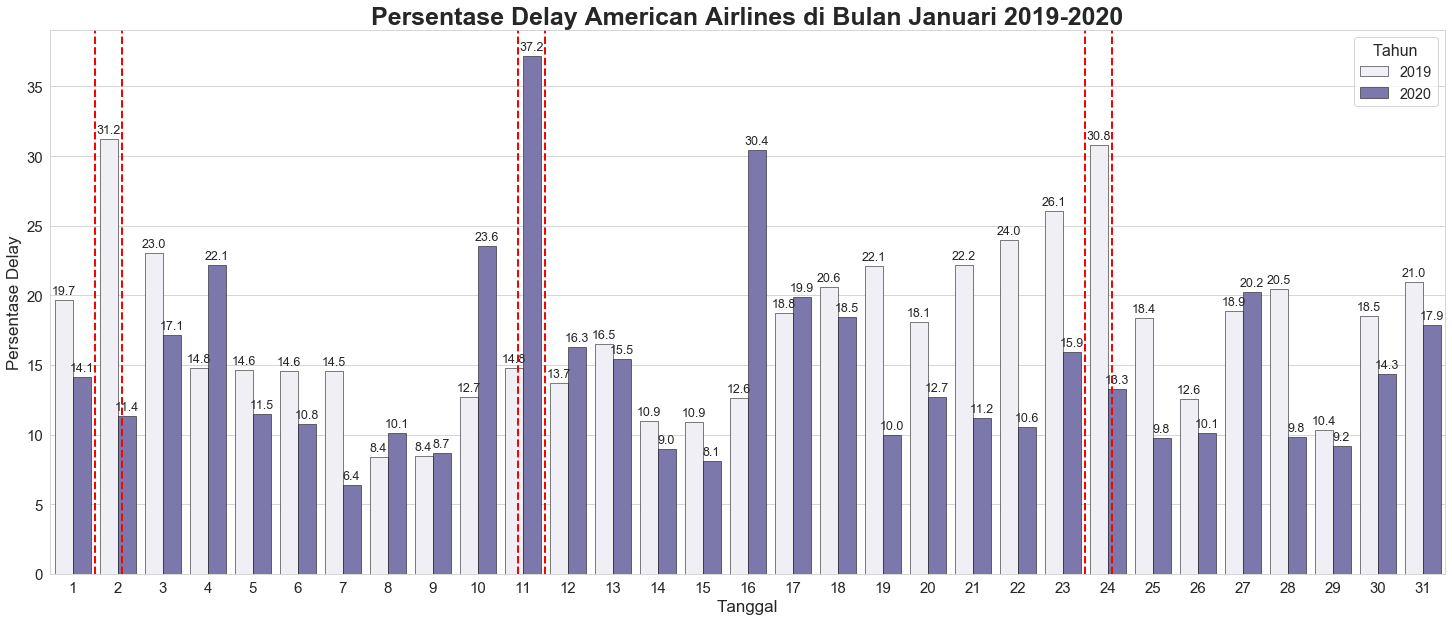

In [52]:
day_1 = data.groupby(['year','DAY_OF_MONTH','ARR_DEL15'])['OP_CARRIER_FL_NUM'].count().reset_index(name='count_delay')
day_2 = data.groupby(['DAY_OF_MONTH','year'])['OP_CARRIER_FL_NUM'].count().reset_index(name='all_count')

day_12 = day_1.merge(day_2, how = 'left', on=['DAY_OF_MONTH','year'])
day_12['percentage'] = day_12['count_delay']*100/day_12['all_count']
day_12 = day_12[day_12['ARR_DEL15']==1.0]
day_12.head()

sns.set_style('whitegrid')
plt.figure(figsize=(25,10))
plot_day=sns.barplot(x="DAY_OF_MONTH", y="percentage", hue='year', data=day_12, color='#7570b3',edgecolor= 'black', linewidth =0.5)
plot_day.set_ylabel("Persentase Delay",fontsize = 17)
plot_day.set_xlabel("Tanggal", fontsize=17)
plot_day.set_title('Persentase Delay American Airlines di Bulan Januari 2019-2020',fontsize=25,fontweight='bold')
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(fontsize='x-large', title_fontsize='16', title='Tahun')

for p in plot_day.patches:
    plot_day.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                       textcoords = 'offset points', size=12.5)
#plt.stackplot(np.arange(22.5, 23 ,0.47), [[15]], colors=('indianred',), alpha=0.3)
plt.axvline(x=22.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=23.1, color='red', linestyle='--', linewidth=2)

#plt.stackplot(np.arange(14.5, 16.5 ,1), [[15]], colors=('indianred',), alpha=0.3)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=1.1, color='red', linestyle='--', linewidth=2)

plt.axvline(x=9.9, color='red', linestyle='--', linewidth=2)
plt.axvline(x=10.5, color='red', linestyle='--', linewidth=2)
plt.savefig('AA_plot_day.png', tight_box=True)

Delay dengan persentase tertinggi terjadi pada tanggal 24 Januari 2019 dan 11 Januari 2020.<br>
Pada 24 Januari 2019 terdapat peristiwa US Shortage Staff yang berdapampak delay pada penerbangan di beberapa airport.<br>
Pada 11 Januari 2020 terdapat Travel alert dikarenakan badai salju yang berdampak pada delay.

## Insight Persentase Delay pada Hari dalam Seminggu

In [53]:
week_1 = data.groupby(['year','DAY_OF_WEEK','ARR_DEL15'])['OP_CARRIER_FL_NUM'].count().reset_index(name='count_delay')
week_2 = data.groupby(['DAY_OF_WEEK','year'])['OP_CARRIER_FL_NUM'].count().reset_index(name='all_count')

week_12 = week_1.merge(week_2, how = 'left', on=['DAY_OF_WEEK','year'])
week_12['percentage'] = week_12['count_delay']*100/week_12['all_count']
week_12 = week_12[week_12['ARR_DEL15']==1.0]
week_12.head()

,year,DAY_OF_WEEK,ARR_DEL15,count_delay,all_count,percentage
1,2019,1,1.0,1670,9887,16.890867
3,2019,2,1.0,1669,11429,14.603202
5,2019,3,1.0,2304,11844,19.452888
7,2019,4,1.0,2638,12433,21.217727
9,2019,5,1.0,1751,10219,17.134749


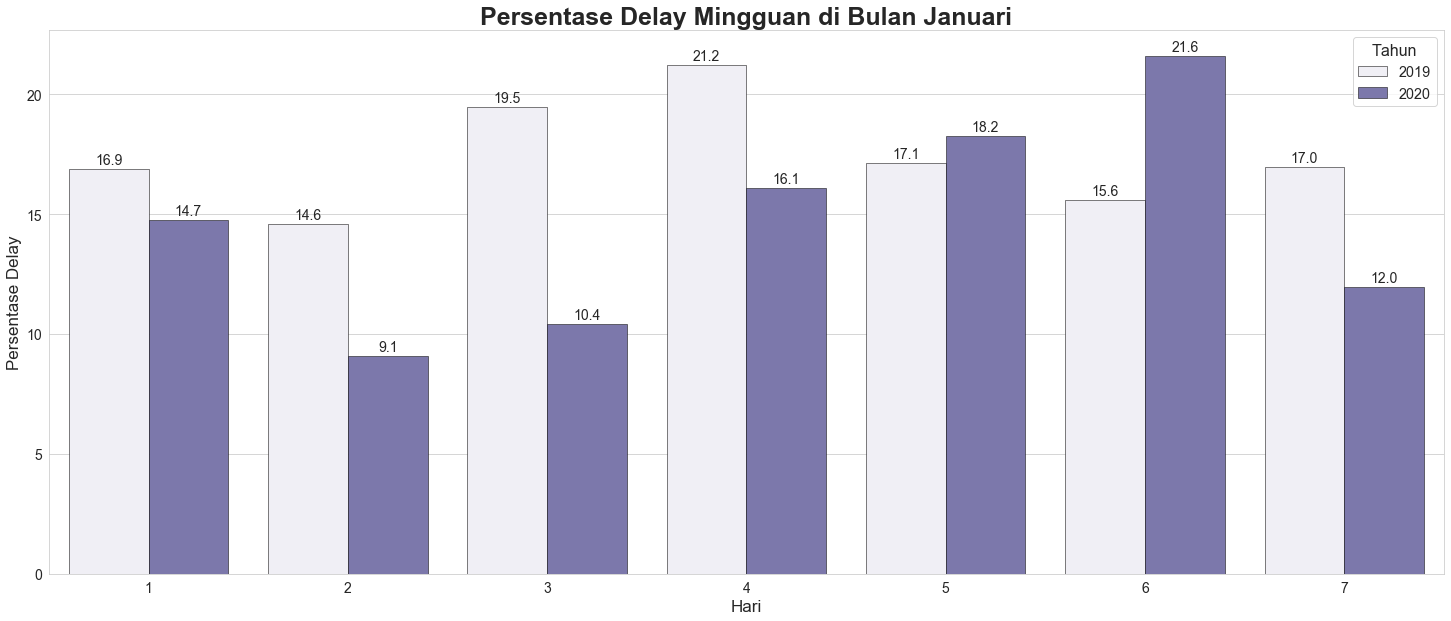

In [54]:
sns.set_style('whitegrid')
plt.figure(figsize=(25,10))
plot_day=sns.barplot(x="DAY_OF_WEEK", y="percentage", hue='year', data=week_12, color='#7570b3',edgecolor= 'black', linewidth =0.5)
plot_day.set_ylabel("Persentase Delay",fontsize = 17)
plot_day.set_xlabel("Hari", fontsize=17)
plot_day.set_title('Persentase Delay Mingguan di Bulan Januari',fontsize=25,fontweight='bold')
for p in plot_day.patches:
    plot_day.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', size=14)

plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(fontsize='x-large', title_fontsize='16', title='Tahun')
plt.savefig('plot_week.png', tight_box=True)

Delay tertinggi terjadi pada hari Kamis (2019) dan Sabtu (2020)

## Insight Persentase Delay pada Time Block

In [55]:
tb_1 = data.groupby(['year','ARR_TIME_BLK','ARR_DEL15'])['OP_CARRIER_FL_NUM'].count().reset_index(name='count_delay')
tb_2 = data.groupby(['ARR_TIME_BLK','year'])['OP_CARRIER_FL_NUM'].count().reset_index(name='all_count')

tb_12 = tb_1.merge(tb_2, how = 'left', on=['ARR_TIME_BLK','year'])
tb_12['percentage'] = tb_12['count_delay']*100/tb_12['all_count']
tb_12 = tb_12[tb_12['ARR_DEL15']==1.0]
tb_12.sort_values(['all_count'], ascending=False).head(10)

,year,ARR_TIME_BLK,ARR_DEL15,count_delay,all_count,percentage
74,2020,1300-1359,1.0,519,4923,10.542352
86,2020,1900-1959,1.0,764,4852,15.746084
30,2019,1500-1559,1.0,733,4823,15.198010
42,2019,2100-2159,1.0,1086,4758,22.824716
26,2019,1300-1359,1.0,600,4741,12.655558
66,2020,0900-0959,1.0,377,4732,7.967033
78,2020,1500-1559,1.0,581,4703,12.353817
68,2020,1000-1059,1.0,566,4697,12.050245
38,2019,1900-1959,1.0,956,4670,20.471092
90,2020,2100-2159,1.0,833,4598,18.116572


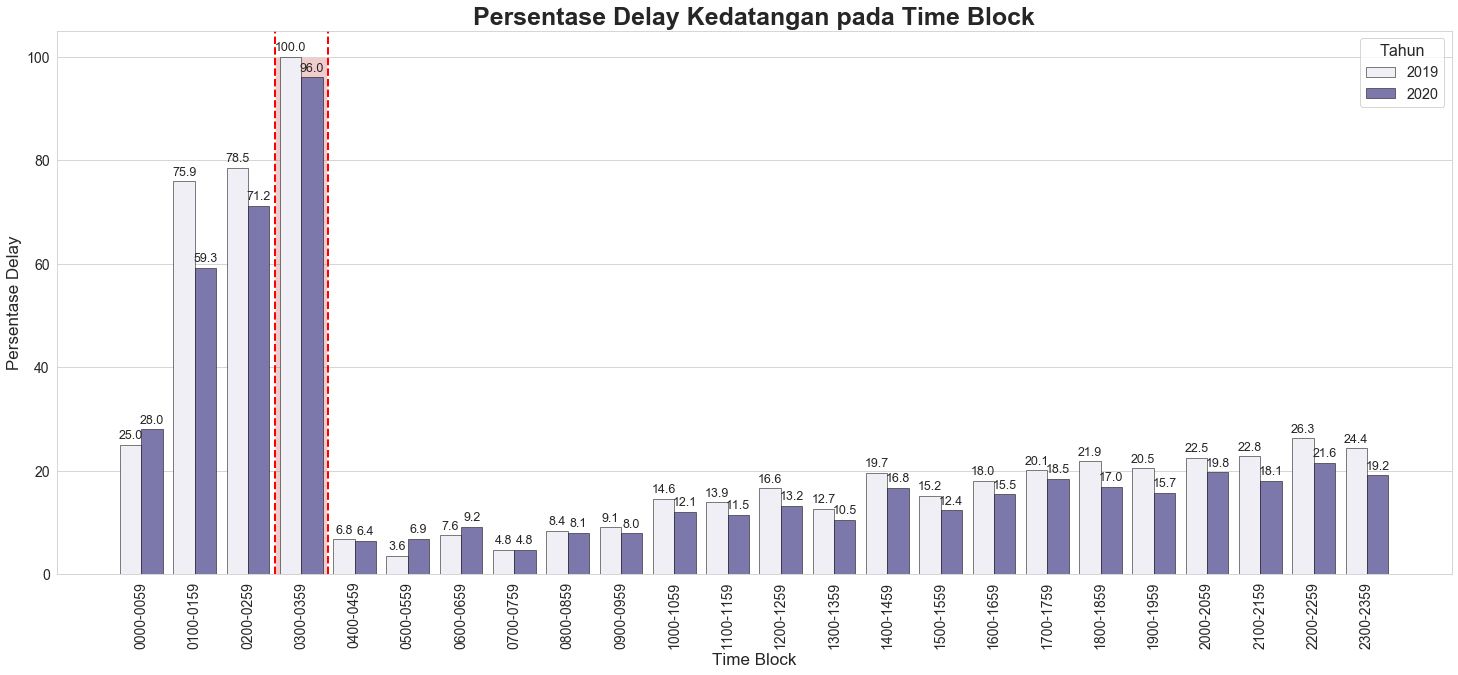

In [56]:
sns.set_style('whitegrid')
plt.figure(figsize=(25,10))
plot_day=sns.barplot(x="ARR_TIME_BLK", y="percentage", hue='year', data=tb_12, color='#7570b3',edgecolor= 'black', linewidth =0.5)
plot_day.set_ylabel("Persentase Delay",fontsize = 17)
plot_day.set_xlabel("Time Block", fontsize=17)
plot_day.set_title('Persentase Delay Kedatangan pada Time Block',fontsize=25,fontweight='bold')
plt.stackplot(np.arange(2.5, 3.5,0.99), [[100]], colors=('indianred',), alpha=0.3)
plt.axvline(x=2.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=3.5, color='red', linestyle='--', linewidth=2)
#plt.text(1,81,s=y[i])
for p in plot_day.patches:
    plot_day.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                       textcoords = 'offset points', size=12.5)

plt.xticks(rotation=90)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(fontsize='x-large', title_fontsize='16', title='Tahun')
plt.savefig('plot_tb.png', tight_box=True)

## Insight Persentase delay pada Kategori Waktu

In [57]:
cm_1 = data.groupby(['year','CAT_TIME','ARR_DEL15'])['OP_CARRIER_FL_NUM'].count().reset_index(name='count_delay')
cm_2 = data.groupby(['CAT_TIME','year'])['OP_CARRIER_FL_NUM'].count().reset_index(name='all_count')

cm_12 = cm_1.merge(cm_2, how = 'left', on=['CAT_TIME','year'])
cm_12['percentage'] = cm_12['count_delay']*100/cm_12['all_count']
cm_12 = cm_12[cm_12['ARR_DEL15']==1.0]
cm_12.head()

,year,CAT_TIME,ARR_DEL15,count_delay,all_count,percentage
1,2019,Afternoon,1.0,4502,26549,16.957324
3,2019,Evening,1.0,5807,25339,22.917242
5,2019,Late night,1.0,396,1255,31.553785
7,2019,Morning,1.0,2150,19952,10.775862
9,2020,Afternoon,1.0,3757,26213,14.332583


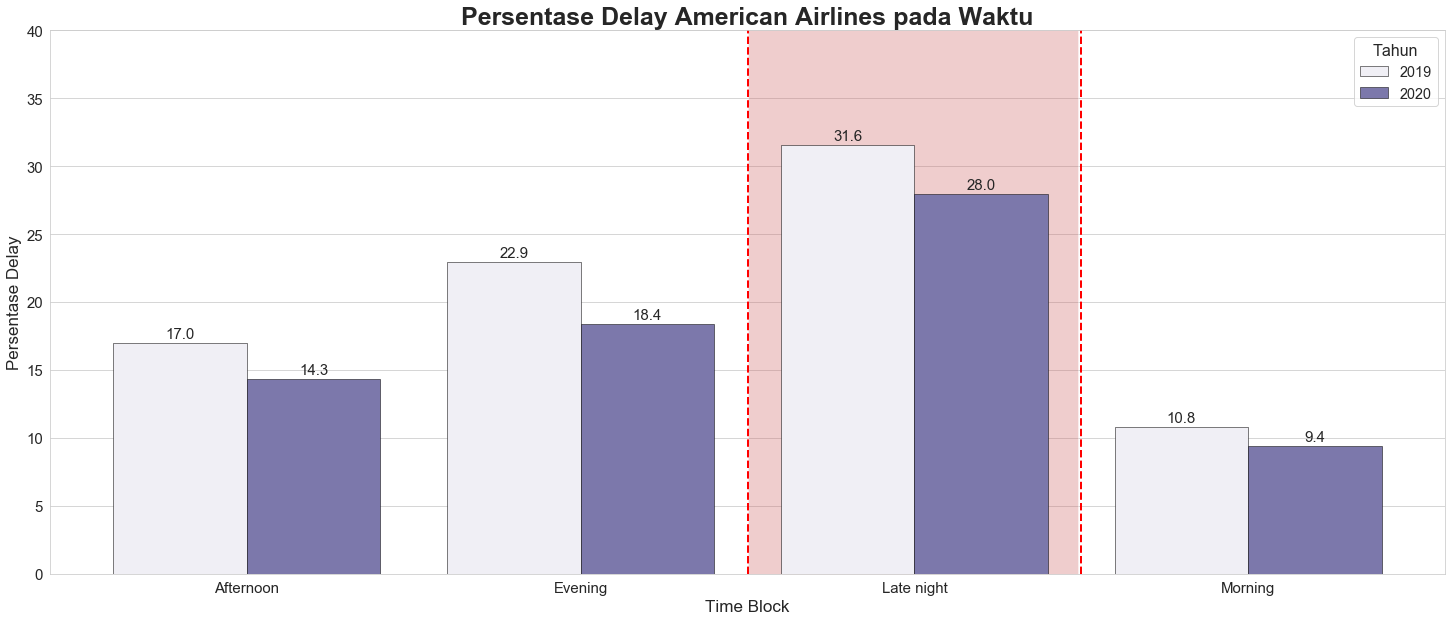

In [99]:
sns.set_style('whitegrid')
plt.figure(figsize=(25,10))
plot_time=sns.barplot(x="CAT_TIME", y="percentage", hue='year', data=cm_12, color='#7570b3',edgecolor= 'black', linewidth =0.5)
plot_time.set_ylabel("Persentase Delay",fontsize = 17)
plot_time.set_xlabel("Time Block", fontsize=17)
plot_time.set_title('Persentase Delay American Airlines pada Waktu',fontsize=25,fontweight='bold')

plt.stackplot(np.arange(1.5, 2.5,0.99), [[40]], colors=('indianred',), alpha=0.3)
plt.axvline(x=1.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='red', linestyle='--', linewidth=2)

for p in plot_day.patches:
    plot_time.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', size=15)
plt.ylim(0,40)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(fontsize='x-large', title_fontsize='16', title='Tahun')
plt.savefig('plot_cm.png', tight_box=True)

Delay pada waktu keberangkatan dengan persentase tertinggi terjadi pada waktu tengah malam.

## Insight Persentase Delay pada Airport Tujuan

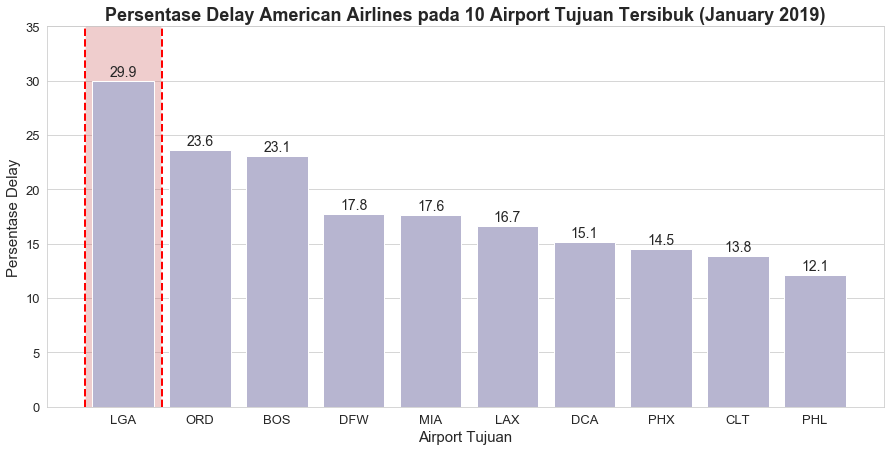

In [59]:
# Delay berdasarkan 5 Airport Tujuan tersibuk tahun 2019
dest_delay19 = data_2019[['DEST','ARR_DEL15']].groupby(['DEST']).sum()
dest_delay19['FREQUENCY'] = data_2019.groupby(['DEST'])['ARR_DEL15'].count()#.sort_values(['FREQUENCY'], ascending=False)
dest_delay19 = dest_delay19.sort_values(['FREQUENCY'], ascending=False)
dest_delay19['PERCENTAGE'] = (dest_delay19['ARR_DEL15']/dest_delay19['FREQUENCY'])*100
dest_delay19['DESTINATION'] = dest_delay19.index
dest_delay19 = dest_delay19.sort_values(['FREQUENCY'], ascending=False).head(10)
dest_delay19 = dest_delay19.sort_values(['PERCENTAGE'], ascending=False)
dest_delay19

plt.figure(figsize=(15,7))
plot_rute=sns.barplot(x="DESTINATION", y="PERCENTAGE", data=dest_delay19, color='#b3b0d5')
plot_rute.set_ylabel("Persentase Delay",fontsize = 15)
plot_rute.set_xlabel("Airport Tujuan",fontsize = 15)
plot_rute.set_title('Persentase Delay American Airlines pada 10 Airport Tujuan Tersibuk (January 2019)',fontsize=18,fontweight='bold')

plt.stackplot(np.arange(-0.5, 0.5,0.99), [[40]], colors=('indianred',), alpha=0.3)
plt.axvline(x=-0.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)

for p in plot_rute.patches:
    plot_rute.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', size=14)
plt.ylim(0,35)
plt.tick_params(axis = 'both', which = 'major', labelsize = 13)
plt.savefig('AA_plot_dest19.png')

Airport Tujuan dengan persentase delay terbanyak pada tahun 2019 adalah LaGuardia International Airport (LGA)

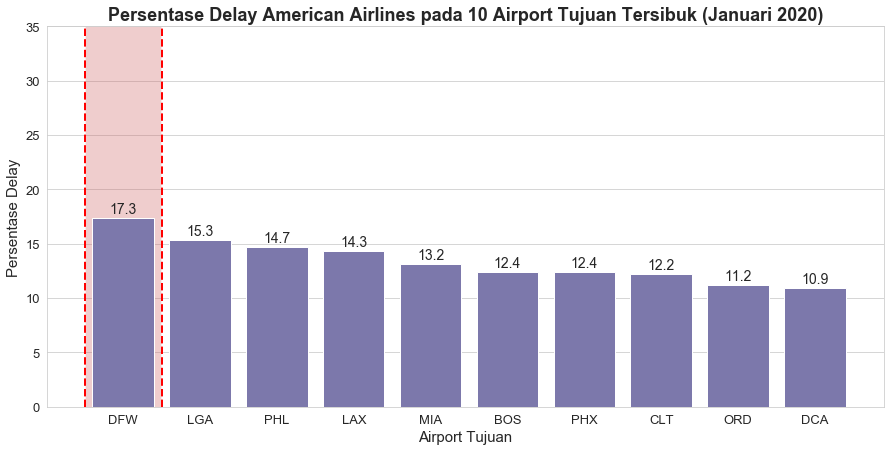

In [60]:
# Delay berdasarkan 5 Airport Tujuan tersibuk tahun 2020
dest_delay20 = data_2020[['DEST','ARR_DEL15']].groupby(['DEST']).sum()
dest_delay20['FREQUENCY'] = data_2020.groupby(['DEST'])['ARR_DEL15'].count()#.sort_values(['FREQUENCY'], ascending=False)
dest_delay20 = dest_delay20.sort_values(['FREQUENCY'], ascending=False)
dest_delay20['PERCENTAGE'] = (dest_delay20['ARR_DEL15']/dest_delay20['FREQUENCY'])*100
dest_delay20['DESTINATION'] = dest_delay20.index
dest_delay20 = dest_delay20.sort_values(['FREQUENCY'], ascending=False).head(10)
dest_delay20 = dest_delay20.sort_values(['PERCENTAGE'], ascending=False)
dest_delay20

plt.figure(figsize=(15,7))
plot_rute=sns.barplot(x="DESTINATION", y="PERCENTAGE", data=dest_delay20, color='#7570b3')
plot_rute.set_ylabel("Persentase Delay", fontsize=15)
plot_rute.set_xlabel("Airport Tujuan", fontsize=15)
plot_rute.set_title('Persentase Delay American Airlines pada 10 Airport Tujuan Tersibuk (Januari 2020)',fontsize=18,fontweight='bold')
plt.stackplot(np.arange(-0.5, 0.5,0.99), [[35]], colors=('indianred',), alpha=0.3)
plt.axvline(x=-0.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
for p in plot_rute.patches:
    plot_rute.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', size=14)
plt.ylim(0,35)
plt.tick_params(axis = 'both', which = 'major', labelsize = 13)
plt.savefig('plot_dest20.png')

Airport Tujuan dengan persentase delay terbanyak pada tahun 2020 adalah Dallas/Fort Worth International Airport (DFW)

In [61]:
#Melihat pertumbuhan delay pada airport tujuan
growth = dest_delay19.merge(dest_delay20, how='inner', on='DESTINATION')
growth['GROWTH'] = growth['PERCENTAGE_y'] - growth['PERCENTAGE_x'] 
growth.sort_values(['FREQUENCY_x', 'PERCENTAGE_x'], ascending=False)

,ARR_DEL15_x,FREQUENCY_x,PERCENTAGE_x,DESTINATION,ARR_DEL15_y,FREQUENCY_y,PERCENTAGE_y,GROWTH
3,2056.0,11579,17.756283,DFW,1997.0,11518,17.338080,-0.418203
8,1105.0,7987,13.834982,CLT,1028.0,8408,12.226451,-1.608531
1,1119.0,4736,23.627534,ORD,491.0,4377,11.217729,-12.409805
7,679.0,4683,14.499253,PHX,625.0,5039,12.403255,-2.095998
4,794.0,4512,17.597518,MIA,568.0,4319,13.151192,-4.446325
9,455.0,3766,12.081784,PHL,482.0,3278,14.704088,2.622303
5,545.0,3271,16.661571,LAX,484.0,3379,14.323764,-2.337807
2,440.0,1905,23.097113,BOS,228.0,1836,12.418301,-10.678812
6,285.0,1883,15.135422,DCA,238.0,2184,10.897436,-4.237986
0,514.0,1717,29.935935,LGA,296.0,1932,15.320911,-14.615024


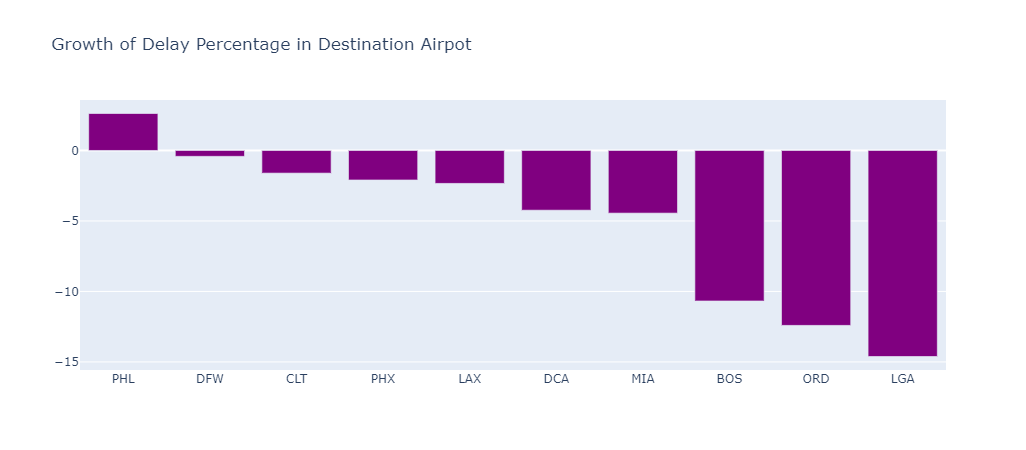

In [62]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
    x=growth.sort_values(by='GROWTH', ascending=False)['DESTINATION'].values,
    y=growth.sort_values(by='GROWTH', ascending=False)['GROWTH'].values,
    marker_color='purple'
))

fig.update_layout(barmode='group',
                 title = 'Growth of Delay Percentage in Destination Airpot')
fig.show()

Airport La Guardia (LGA) berhasil menurunkan 19% delay dari tahun 2019-2020. Sedangkan Philadelphia Airport bertambah persentase delaynya sebanyak 0.66%.

## Insight Persentase Delay berdasarkan Rute Penerbangan

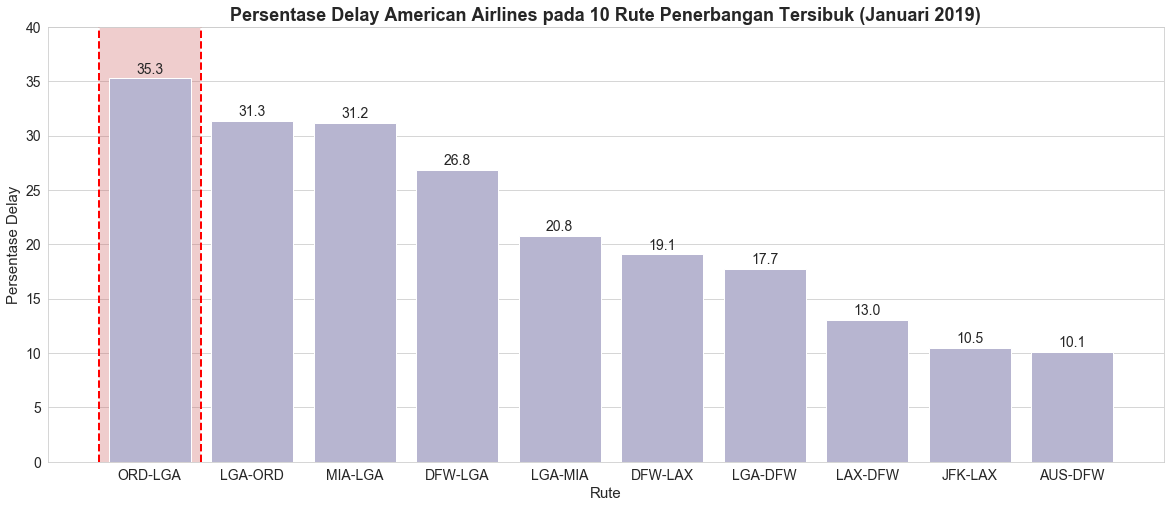

In [63]:
#delay berdasarkan 5 rute penerbangan tersibuk tahun 2019
delay_route19 = data_2019[['ROUTE','ARR_DEL15']].groupby(['ROUTE']).sum()
delay_route19['FREQUENCY'] = data_2019.groupby(['ROUTE'])['ARR_DEL15'].count()
delay_route19['PERCENTAGE'] = (delay_route19['ARR_DEL15']/delay_route19['FREQUENCY'])*100
delay_route19['ROUTE'] = delay_route19.index
delay_route19 = delay_route19.sort_values(['FREQUENCY'], ascending=False).head(10)
delay_route19 = delay_route19.sort_values(['PERCENTAGE'], ascending=False)

plt.figure(figsize=(20,8))
plot_rute=sns.barplot(x="ROUTE", y="PERCENTAGE", data=delay_route19, color='#b3b0d5')
plot_rute.set_ylabel("Persentase Delay", fontsize=15)
plot_rute.set_xlabel("Rute", fontsize=15)

plt.stackplot(np.arange(-0.5, 0.5,0.99), [[40]], colors=('indianred',), alpha=0.3)
plt.axvline(x=-0.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
for p in plot_rute.patches:
    plot_rute.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', size=14)
plt.ylim(0,40)
plot_rute.set_title('Persentase Delay American Airlines pada 10 Rute Penerbangan Tersibuk (Januari 2019)',fontsize=18,fontweight='bold')
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.savefig('plot_rute19.png')

Persentase rute penerbangan dengan delay terbanyak di tahun 2019 adalah rute penerbangan dari Chicago O'Hare International Airport (ORD) menuju La Guardia Airport (LGA)

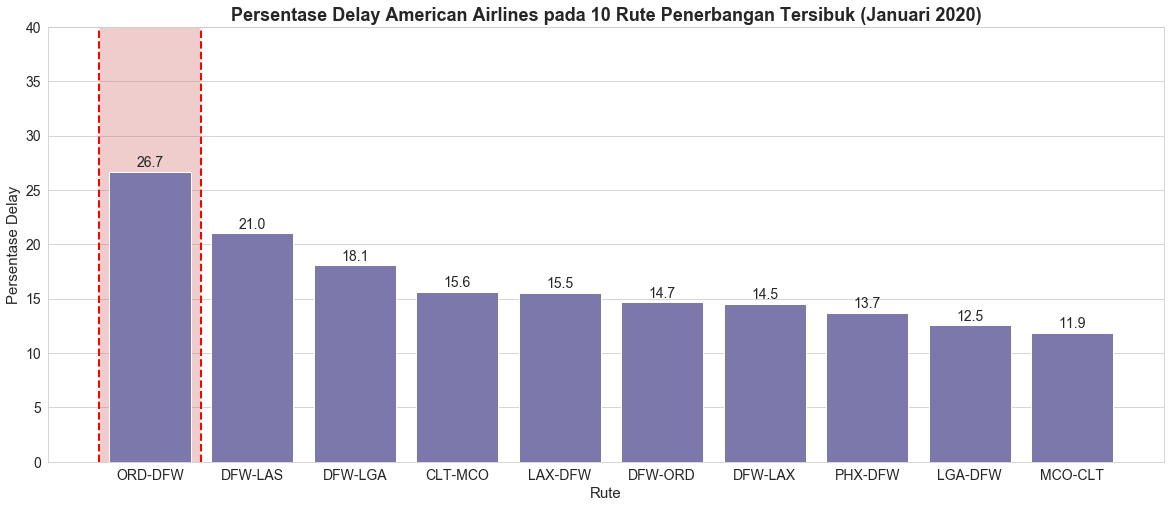

In [64]:
#delay berdasarkan 5 rute penerbangan tersibuk tahun 2020
delay_route20 = data_2020[['ROUTE','ARR_DEL15']].groupby(['ROUTE']).sum()
delay_route20['FREQUENCY'] = data_2020.groupby(['ROUTE'])['ARR_DEL15'].count()
delay_route20['PERCENTAGE'] = (delay_route20['ARR_DEL15']/delay_route20['FREQUENCY'])*100
delay_route20['ROUTE'] = delay_route20.index
delay_route20 = delay_route20.sort_values(['FREQUENCY'], ascending=False).head(10)
delay_route20 = delay_route20.sort_values(['PERCENTAGE'], ascending=False)

plt.figure(figsize=(20,8))
plot_rute=sns.barplot(x="ROUTE", y="PERCENTAGE", data=delay_route20, color='#7570b3')
plot_rute.set_ylabel("Persentase Delay", fontsize=15)
plot_rute.set_xlabel("Rute", fontsize=15)
plt.stackplot(np.arange(-0.5, 0.5,0.99), [[40]], colors=('indianred',), alpha=0.3)
plt.axvline(x=-0.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
for p in plot_rute.patches:
    plot_rute.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', size=14)
plt.ylim(0,40)
plot_rute.set_title('Persentase Delay American Airlines pada 10 Rute Penerbangan Tersibuk (Januari 2020)',fontsize=18,fontweight='bold')
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.savefig('plot_rute20.png')

Persentase rute penerbangan dengan delay terbanyak di tahun 2020 adalah rute penerbangan dari Chicago O'Hare International Airport (ORD) menuju Dallas Fort International Airport (DFW).

## Insight Durasi Penerbangan

In [65]:
d1 = data.groupby(['CAT_DURATION', 'ARR_DEL15'])['OP_CARRIER_FL_NUM'].count().reset_index(name='count')
d2 = data.groupby(['CAT_DURATION'])['OP_CARRIER_FL_NUM'].count().reset_index(name='all_count')

d12 = d1.merge(d2, how = 'inner', on='CAT_DURATION')
d12['percentage'] = d12['count']*100/d12['all_count']
d12

,CAT_DURATION,ARR_DEL15,count,all_count,percentage
0,Long,0.0,7671,9794,78.323463
1,Long,1.0,2123,9794,21.676537
2,Medium,0.0,28978,36047,80.389491
3,Medium,1.0,7069,36047,19.610509
4,Short,0.0,86123,100486,85.706467
5,Short,1.0,14363,100486,14.293533


Text(0.5, 1.0, 'Persentase Delay pada Durasi Penerbangan')

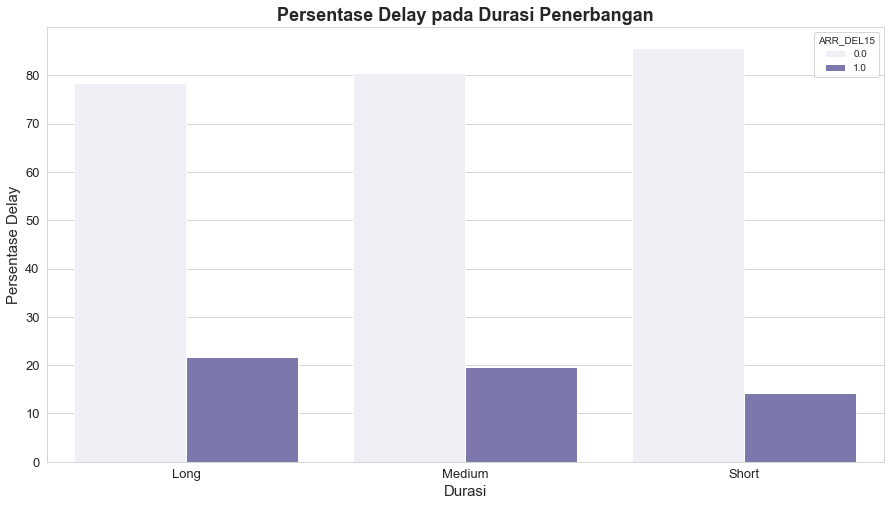

In [66]:
plt.figure(figsize=(15,8))
plot_durasi=sns.barplot(x="CAT_DURATION", y="percentage", hue='ARR_DEL15', data=d12, color='#7570b3')
plot_durasi.set_ylabel("Persentase Delay", fontsize=15)
plot_durasi.set_xlabel("Durasi", fontsize=15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 13)
plot_durasi.set_title('Persentase Delay pada Durasi Penerbangan',fontsize=18,fontweight='bold')

Delay cenderung sering terjadi pada penerbangan dengan durasi panjang (>6 jam) dan durasi menengah (3-6 jam)

# Data Pre-processing sebelum modelling

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146327 entries, 222 to 1139850
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   DAY_OF_MONTH       146327 non-null  int8           
 1   DAY_OF_WEEK        146327 non-null  int8           
 2   OP_UNIQUE_CARRIER  146327 non-null  object         
 3   OP_CARRIER_FL_NUM  146327 non-null  int16          
 4   ORIGIN             146327 non-null  object         
 5   DEST               146327 non-null  object         
 6   DEP_TIME           146327 non-null  float16        
 7   DEP_DEL15          146327 non-null  float16        
 8   DEP_TIME_BLK       146327 non-null  object         
 9   ARR_TIME           146327 non-null  float16        
 10  ARR_DEL15          146327 non-null  float16        
 11  DISTANCE           146327 non-null  float16        
 12  year               146327 non-null  int16          
 13  DATE               146327 

## Pengurangan Fitur

In [68]:
data=data.drop(['OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DATE', 'ARR_TIME', 'DEP_TIME', 'dt_DEP_TIME', 'dt_ARR_TIME', 'DURATION','DEP_TIME_BLK'], axis=1)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146327 entries, 222 to 1139850
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   DAY_OF_MONTH       146327 non-null  int8    
 1   DAY_OF_WEEK        146327 non-null  int8    
 2   OP_UNIQUE_CARRIER  146327 non-null  object  
 3   DEP_DEL15          146327 non-null  float16 
 4   ARR_DEL15          146327 non-null  float16 
 5   DISTANCE           146327 non-null  float16 
 6   year               146327 non-null  int16   
 7   CAT_DURATION       146327 non-null  object  
 8   ROUTE              146327 non-null  object  
 9   ARR_TIME_BLK       146327 non-null  object  
 10  CAT_TIME           146327 non-null  object  
 11  CAT_DISTANCE       146327 non-null  category
dtypes: category(1), float16(3), int16(1), int8(2), object(5)
memory usage: 13.2+ MB


## One Hot Encoding untuk Kategori Durasi

In [70]:
dummies_duration = pd.get_dummies(data['CAT_DURATION'],prefix='CAT_DURATION')
data = pd.concat([data, dummies_duration], axis=1)
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEP_DEL15,ARR_DEL15,DISTANCE,year,CAT_DURATION,ROUTE,ARR_TIME_BLK,CAT_TIME,CAT_DISTANCE,CAT_DURATION_Long,CAT_DURATION_Medium,CAT_DURATION_Short
222,1,2,AA,1.0,1.0,1797.0,2019,Short,BNA-LAX,2200-2259,Evening,q4,0,0,1
223,1,2,AA,1.0,1.0,1797.0,2019,Medium,LAX-BNA,1900-1959,Evening,q4,0,1,0
224,1,2,AA,0.0,0.0,1438.0,2019,Short,DFW-SJC,2000-2059,Evening,q4,0,0,1
225,1,2,AA,1.0,0.0,1235.0,2019,Medium,LAX-DFW,2000-2059,Evening,q4,0,1,0
226,1,2,AA,0.0,0.0,733.0,2019,Short,LGA-ORD,1400-1459,Afternoon,q3,0,0,1


## One Hot Encoding untuk Kategori Waktu

In [71]:
dummies_time = pd.get_dummies(data['CAT_TIME'],prefix='CAT_TIME')
data = pd.concat([data, dummies_time], axis=1)
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEP_DEL15,ARR_DEL15,DISTANCE,year,CAT_DURATION,ROUTE,ARR_TIME_BLK,CAT_TIME,CAT_DISTANCE,CAT_DURATION_Long,CAT_DURATION_Medium,CAT_DURATION_Short,CAT_TIME_Afternoon,CAT_TIME_Evening,CAT_TIME_Late night,CAT_TIME_Morning
222,1,2,AA,1.0,1.0,1797.0,2019,Short,BNA-LAX,2200-2259,Evening,q4,0,0,1,0,1,0,0
223,1,2,AA,1.0,1.0,1797.0,2019,Medium,LAX-BNA,1900-1959,Evening,q4,0,1,0,0,1,0,0
224,1,2,AA,0.0,0.0,1438.0,2019,Short,DFW-SJC,2000-2059,Evening,q4,0,0,1,0,1,0,0
225,1,2,AA,1.0,0.0,1235.0,2019,Medium,LAX-DFW,2000-2059,Evening,q4,0,1,0,0,1,0,0
226,1,2,AA,0.0,0.0,733.0,2019,Short,LGA-ORD,1400-1459,Afternoon,q3,0,0,1,1,0,0,0


## One Hot Encoding untuk Kategori Jarak

In [72]:
dummies_distance = pd.get_dummies(data['CAT_DISTANCE'],prefix='CAT_DISTANCE')
data = pd.concat([data, dummies_distance], axis=1)
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEP_DEL15,ARR_DEL15,DISTANCE,year,CAT_DURATION,ROUTE,ARR_TIME_BLK,...,CAT_DURATION_Medium,CAT_DURATION_Short,CAT_TIME_Afternoon,CAT_TIME_Evening,CAT_TIME_Late night,CAT_TIME_Morning,CAT_DISTANCE_q1,CAT_DISTANCE_q2,CAT_DISTANCE_q3,CAT_DISTANCE_q4
222,1,2,AA,1.0,1.0,1797.0,2019,Short,BNA-LAX,2200-2259,...,0,1,0,1,0,0,0,0,0,1
223,1,2,AA,1.0,1.0,1797.0,2019,Medium,LAX-BNA,1900-1959,...,1,0,0,1,0,0,0,0,0,1
224,1,2,AA,0.0,0.0,1438.0,2019,Short,DFW-SJC,2000-2059,...,0,1,0,1,0,0,0,0,0,1
225,1,2,AA,1.0,0.0,1235.0,2019,Medium,LAX-DFW,2000-2059,...,1,0,0,1,0,0,0,0,0,1
226,1,2,AA,0.0,0.0,733.0,2019,Short,LGA-ORD,1400-1459,...,0,1,1,0,0,0,0,0,1,0


In [73]:
data.shape

(146327, 23)

## Hitung Jumlah Delay pada ARR_TIME_BLK

In [74]:
#Number of delays ARR_DEL15 per ARR_TIME_BLK
count_time_blk = data[['ARR_TIME_BLK','ARR_DEL15']].groupby('ARR_TIME_BLK').sum().sort_values(['ARR_DEL15'],ascending=False)
count_time_blk.reset_index(inplace=True)
count_time_blk.head()
data = data.merge(count_time_blk, left_on='ARR_TIME_BLK', right_on='ARR_TIME_BLK') 
data.rename({'ARR_DEL15_y':'delay_arr_time_blk','ARR_DEL15_x':'ARR_DEL15' }, inplace=True, axis=1)
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEP_DEL15,ARR_DEL15,DISTANCE,year,CAT_DURATION,ROUTE,ARR_TIME_BLK,...,CAT_DURATION_Short,CAT_TIME_Afternoon,CAT_TIME_Evening,CAT_TIME_Late night,CAT_TIME_Morning,CAT_DISTANCE_q1,CAT_DISTANCE_q2,CAT_DISTANCE_q3,CAT_DISTANCE_q4,delay_arr_time_blk
0,1,2,AA,1.0,1.0,1797.0,2019,Short,BNA-LAX,2200-2259,...,1,0,1,0,0,0,0,0,1,1751.0
1,1,2,AA,0.0,0.0,280.0,2019,Short,PHL-BOS,2200-2259,...,1,0,1,0,0,1,0,0,0,1751.0
2,1,2,AA,0.0,0.0,2248.0,2019,Medium,JFK-LAS,2200-2259,...,0,0,1,0,0,0,0,0,1,1751.0
3,1,2,AA,1.0,0.0,2476.0,2019,Long,LAX-JFK,2200-2259,...,0,0,1,0,0,0,0,0,1,1751.0
4,1,2,AA,0.0,1.0,2556.0,2019,Long,HNL-LAX,2200-2259,...,0,0,1,0,0,0,0,0,1,1751.0


## Hitung Jumlah Delay pada Rute

In [75]:
#Number of delays ARR_DEL15 per ROUTE.
count_later_route = data[['ROUTE','ARR_DEL15']].groupby('ROUTE').sum().sort_values(by='ARR_DEL15',ascending=False)
count_later_route.reset_index(inplace=True)
count_later_route.head()
data_final = data.merge(count_later_route, left_on='ROUTE', right_on='ROUTE')
data_final.rename({'ARR_DEL15_y':'delay_route','ARR_DEL15_x':'ARR_DEL15' }, inplace=True, axis=1)
data_final.head() 

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEP_DEL15,ARR_DEL15,DISTANCE,year,CAT_DURATION,ROUTE,ARR_TIME_BLK,...,CAT_TIME_Afternoon,CAT_TIME_Evening,CAT_TIME_Late night,CAT_TIME_Morning,CAT_DISTANCE_q1,CAT_DISTANCE_q2,CAT_DISTANCE_q3,CAT_DISTANCE_q4,delay_arr_time_blk,delay_route
0,1,2,AA,1.0,1.0,1797.0,2019,Short,BNA-LAX,2200-2259,...,0,1,0,0,0,0,0,1,1751.0,14.0
1,5,6,AA,0.0,0.0,1797.0,2019,Medium,BNA-LAX,2200-2259,...,0,1,0,0,0,0,0,1,1751.0,14.0
2,7,1,AA,0.0,1.0,1797.0,2019,Medium,BNA-LAX,2200-2259,...,0,1,0,0,0,0,0,1,1751.0,14.0
3,3,5,AA,0.0,0.0,1797.0,2020,Short,BNA-LAX,2200-2259,...,0,1,0,0,0,0,0,1,1751.0,14.0
4,10,5,AA,1.0,1.0,1797.0,2020,Medium,BNA-LAX,2200-2259,...,0,1,0,0,0,0,0,1,1751.0,14.0


## Balancing Data

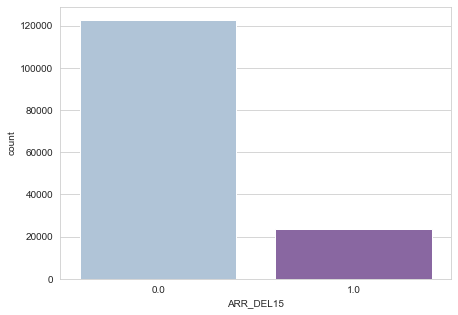

In [76]:
fig, ax = plt.subplots(figsize=(7,5))
sns.countplot('ARR_DEL15', data=data, palette='BuPu')

In [77]:
y = data_final['ARR_DEL15']
x = data_final.drop(labels = ['DISTANCE', 'ARR_DEL15', 'DEP_DEL15', 'OP_UNIQUE_CARRIER', 'ROUTE','ARR_TIME_BLK', 'CAT_DURATION', 'CAT_TIME','CAT_DISTANCE'], axis = 1)

In [78]:
#balancing
X_over_smote, y_over_smote = over_sampling.SMOTE().fit_resample(x, y)

data_over_smote = pd.concat([X_over_smote, y_over_smote], axis=1)

In [79]:
data_over_smote.duplicated().sum()

36711

In [80]:
data_over_smote = data_over_smote.drop_duplicates()

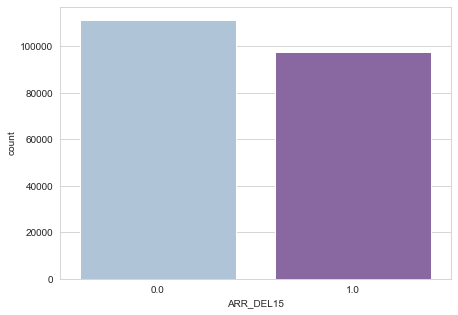

In [81]:
fig, ax = plt.subplots(figsize=(7,5))
sns.countplot('ARR_DEL15', data=data_over_smote, palette='BuPu')

In [82]:
data_over_smote

,DAY_OF_MONTH,DAY_OF_WEEK,year,CAT_DURATION_Long,CAT_DURATION_Medium,CAT_DURATION_Short,CAT_TIME_Afternoon,CAT_TIME_Evening,CAT_TIME_Late night,CAT_TIME_Morning,CAT_DISTANCE_q1,CAT_DISTANCE_q2,CAT_DISTANCE_q3,CAT_DISTANCE_q4,delay_arr_time_blk,delay_route,ARR_DEL15
0,1,2,2019,0,0,1,0,1,0,0,0,0,0,1,1751.0,14.000000,1.0
1,5,6,2019,0,1,0,0,1,0,0,0,0,0,1,1751.0,14.000000,0.0
2,7,1,2019,0,1,0,0,1,0,0,0,0,0,1,1751.0,14.000000,1.0
3,3,5,2020,0,0,1,0,1,0,0,0,0,0,1,1751.0,14.000000,0.0
4,10,5,2020,0,1,0,0,1,0,0,0,0,0,1,1751.0,14.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245536,16,4,2020,0,0,1,0,1,0,0,0,0,0,0,1919.0,7.191406,1.0
245537,20,7,2019,0,0,1,0,1,0,0,0,0,1,0,1632.0,27.187500,1.0
245539,30,3,2019,0,0,1,0,0,0,1,0,0,1,0,1235.0,26.671875,1.0
245540,17,4,2019,0,0,0,1,0,0,0,0,0,0,1,1184.0,85.875000,1.0


In [83]:
data_final_2019 = data_over_smote[data_over_smote['year']==2019]
data_final_2020 = data_over_smote[data_over_smote['year']==2020]

# Modelling

## Logistic Regression

In [84]:
y = data_over_smote['ARR_DEL15']
x = data_over_smote.drop(labels = ['ARR_DEL15','year'], axis = 1)

from sklearn.model_selection import train_test_split 
x_train, x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [85]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0)
logreg.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [86]:
y_pred = logreg.predict(x_test)
y_pred

array([0., 0., 1., ..., 0., 0., 0.], dtype=float16)

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
print('\naccuracy')
print(accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report
print('\nclassification report')
print(classification_report(y_test, y_pred)) # generate the precision, recall, f-1 score, num

from sklearn.metrics import roc_auc_score
print('\nAUC Score')
print(roc_auc_score(y_test, y_pred))


confusion matrix
[[28112  5185]
 [10918 18435]]

accuracy
0.7429688747007183

classification report
              precision    recall  f1-score   support

         0.0       0.72      0.84      0.78     33297
         1.0       0.78      0.63      0.70     29353

    accuracy                           0.74     62650
   macro avg       0.75      0.74      0.74     62650
weighted avg       0.75      0.74      0.74     62650


AUC Score
0.7361625495334357


## Decision Tree

In [88]:
# Fitting model Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
print('\nconfustion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
print('\naccuracy')
print(accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report
print('\nclassification report')
print(classification_report(y_test, y_pred)) # generate the precision, recall, f-1 score, num

from sklearn.metrics import roc_auc_score
print('\nAUC Score')
print(roc_auc_score(y_test, y_pred))


confustion matrix
[[27476  5821]
 [ 5708 23645]]

accuracy
0.8159776536312849

classification report
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     33297
         1.0       0.80      0.81      0.80     29353

    accuracy                           0.82     62650
   macro avg       0.82      0.82      0.82     62650
weighted avg       0.82      0.82      0.82     62650


AUC Score
0.8153594567262386


## XGBoost

In [90]:
from xgboost import XGBClassifier

xg = XGBClassifier(random_state=0)
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)

[14:03:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
print('\naccuracy')
print(accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report
print('\nclassification report')
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print('\nAUC Score')
print(roc_auc_score(y_test, y_pred))


confusion matrix
[[32813   484]
 [ 7326 22027]]

accuracy
0.8753391859537111

classification report
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.89     33297
         1.0       0.98      0.75      0.85     29353

    accuracy                           0.88     62650
   macro avg       0.90      0.87      0.87     62650
weighted avg       0.89      0.88      0.87     62650


AUC Score
0.867940744881481


In [92]:
print("train Accuracy : ",xg.score(x_train,y_train))
print("test Accuracy : ",xg.score(x_test,y_test))

train Accuracy :  0.8796166448903088
test Accuracy :  0.8753391859537111


## Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

In [94]:
from sklearn.metrics import classification_report, confusion_matrix
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
print('\naccuracy')
print(accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report
print('\nclassification report')
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print('\nAUC Score')
print(roc_auc_score(y_test, y_pred))


confusion matrix
[[28023  5274]
 [13521 15832]]

accuracy
0.7

classification report
              precision    recall  f1-score   support

         0.0       0.67      0.84      0.75     33297
         1.0       0.75      0.54      0.63     29353

    accuracy                           0.70     62650
   macro avg       0.71      0.69      0.69     62650
weighted avg       0.71      0.70      0.69     62650


AUC Score
0.6904865022937687


Dari perbandingan keempat model, model yang memiliki performa baik (Recall) adalah model XGBoost.

Text(0.5, 1.0, 'feature importance score')

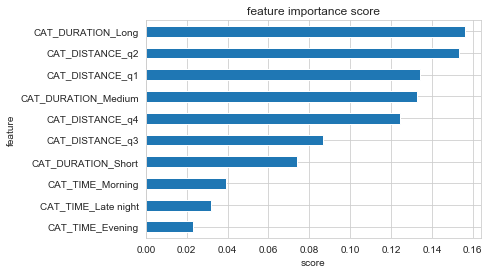

In [95]:
feat_importances = pd.Series(xg.feature_importances_, index=x.columns)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

## Hyperparameter Tuning (XGBoost)

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                    "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
                    "min_child_weight": [ 1, 3, 5, 7 ],
                    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                    "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ],
                    "eta":[.3, .2, .1, .05, .01, .005]
                  }

# Init Logres dengan Gridsearch, cross validation = 5
xg = XGBClassifier(random_state=0)
clf = RandomizedSearchCV(xg, hyperparameters, cv=5, scoring='f1')

#Fitting Model
best_model = clf.fit(x_train,y_train)

#Nilai hyperparameters terbaik
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])

y_predicted = best_model.predict(x_test)#Check performa dari model

from sklearn.metrics import classification_report, confusion_matrix
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, y_predicted))

print(classification_report(y_test, y_predicted))

from sklearn.metrics import roc_auc_score
print('\nAUC Score')
print(roc_auc_score(y_test, y_predicted))

[14:03:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel